#Rifinitura dataset#

In [1]:
#importo le librerie
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import HDBSCAN #riguarda le statistiche di edi e vedi
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
#carico datset originale
folderpath = "/content/speeddating.csv"
dataset = pd.read_csv(folderpath)

In [3]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 123 columns):
 #    Column                           Dtype  
---   ------                           -----  
 0    has_null                         object 
 1    wave                             float64
 2    gender                           object 
 3    age                              float64
 4    age_o                            float64
 5    d_age                            float64
 6    d_d_age                          object 
 7    race                             object 
 8    race_o                           object 
 9    samerace                         object 
 10   importance_same_race             float64
 11   importance_same_religion         float64
 12   d_importance_same_race           object 
 13   d_importance_same_religion       object 
 14   field                            object 
 15   pref_o_attractive                float64
 16   pref_o_sincere                   float64

In [4]:
dataset = dataset.rename(columns={"intellicence_important": "intelligence_important", "ambtition_important": "ambition_important"})

In [5]:
def grafici(x):
   fig, ax = plt.subplots(1,3, figsize=(15,5))
   palette = sns.color_palette("Set2", n_colors=20)
   color = random.choice(palette)
   plt.xlabel(x.name)
   sns.histplot(x, kde=True, stat="density", ax=ax[0], color=color)
   plt.xlabel(x.name)
   sns.histplot(x, ax=ax[1], color=color)
   plt.xlabel(x.name)
   sns.boxplot(x, ax=ax[2], color=color)

#Scelta features#

In [6]:
partner_attributes = ['age_o',
                      'attractive_important',
                      'sincere_important',
                      'intelligence_important',
                      'funny_important',
                      'ambition_important'
                      ]
self_description = ['age',
                    'attractive',
                    'sincere',
                    'intelligence',
                    'funny',
                    'ambition',
                    'gender'
                    ]
interests = ['sports',
            'tvsports',
            'exercise',
            'dining',
            'museums',
            'art',
            'hiking',
            'gaming',
            'clubbing',
            'reading',
            'tv',
            'theater',
            'movies',
            'concerts',
            'music',
            'shopping',
            'yoga'
             ]

In [7]:
dataset_v1 = pd.DataFrame()
dataset_v1[partner_attributes] = dataset[partner_attributes]
dataset_v1[self_description] = dataset[self_description]
dataset_v1[interests] = dataset[interests]
dataset_v1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_o                   8274 non-null   float64
 1   attractive_important    8299 non-null   float64
 2   sincere_important       8299 non-null   float64
 3   intelligence_important  8299 non-null   float64
 4   funny_important         8289 non-null   float64
 5   ambition_important      8279 non-null   float64
 6   age                     8283 non-null   float64
 7   attractive              8273 non-null   float64
 8   sincere                 8273 non-null   float64
 9   intelligence            8273 non-null   float64
 10  funny                   8273 non-null   float64
 11  ambition                8273 non-null   float64
 12  gender                  8378 non-null   object 
 13  sports                  8299 non-null   float64
 14  tvsports                8299 non-null   

#Valori Nulli#
Per tutte le features è stata usata la moda

In [8]:
dataset_v1.isna().sum()

age_o                     104
attractive_important       79
sincere_important          79
intelligence_important     79
funny_important            89
ambition_important         99
age                        95
attractive                105
sincere                   105
intelligence              105
funny                     105
ambition                  105
gender                      0
sports                     79
tvsports                   79
exercise                   79
dining                     79
museums                    79
art                        79
hiking                     79
gaming                     79
clubbing                   79
reading                    79
tv                         79
theater                    79
movies                     79
concerts                   79
music                      79
shopping                   79
yoga                       79
dtype: int64

In [9]:
for column in dataset_v1:
    if not dataset_v1[column].mode().empty:
        mode_value = dataset_v1[column].mode()[0]
        #print('column= {}, mode= {}\n'.format(column,mode_value))
        dataset_v1[column] = dataset_v1[column].fillna(mode_value)

In [10]:
dataset_v1.isna().sum()

age_o                     0
attractive_important      0
sincere_important         0
intelligence_important    0
funny_important           0
ambition_important        0
age                       0
attractive                0
sincere                   0
intelligence              0
funny                     0
ambition                  0
gender                    0
sports                    0
tvsports                  0
exercise                  0
dining                    0
museums                   0
art                       0
hiking                    0
gaming                    0
clubbing                  0
reading                   0
tv                        0
theater                   0
movies                    0
concerts                  0
music                     0
shopping                  0
yoga                      0
dtype: int64

#Conversioni variabili categoriche in numeriche#

gender:


*   male -> 1
*   female -> 2



In [11]:
dataset_v2 = dataset_v1.copy()
dataset_v2['gender'] = dataset_v2['gender'].where(dataset_v2['gender'] != "b'female'", 2.)
dataset_v2['gender'] = dataset_v2['gender'].where(dataset_v2['gender'] != "b'male'", 1.)
dataset_v2['gender']= pd.to_numeric(dataset_v2['gender']) # per convertire in float

#Generazione features mancanti#

*   Città: longitudine e latitudine
*   Gender cercato array 3 posizioni: he\him (1), she\her (2), they,them(3)

i valori tra parentesi sono sia le posizioni del genere che il valore ad esso associato
*   Gender user: inserimento terza categoria  they,them(3)
*   Range età partner: centrato in age_o

In [12]:
dataset_v3 = dataset_v2.copy()

**città**
latitudine e longitudine generate su chat gpt e caricati nel dataset

In [13]:
città = pd.read_csv('/content/italian_cities.csv')
città.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       8378 non-null   object 
 1   Latitude   8378 non-null   float64
 2   Longitude  8378 non-null   float64
dtypes: float64(2), object(1)
memory usage: 196.5+ KB


Text(0.5, 1.0, 'città')

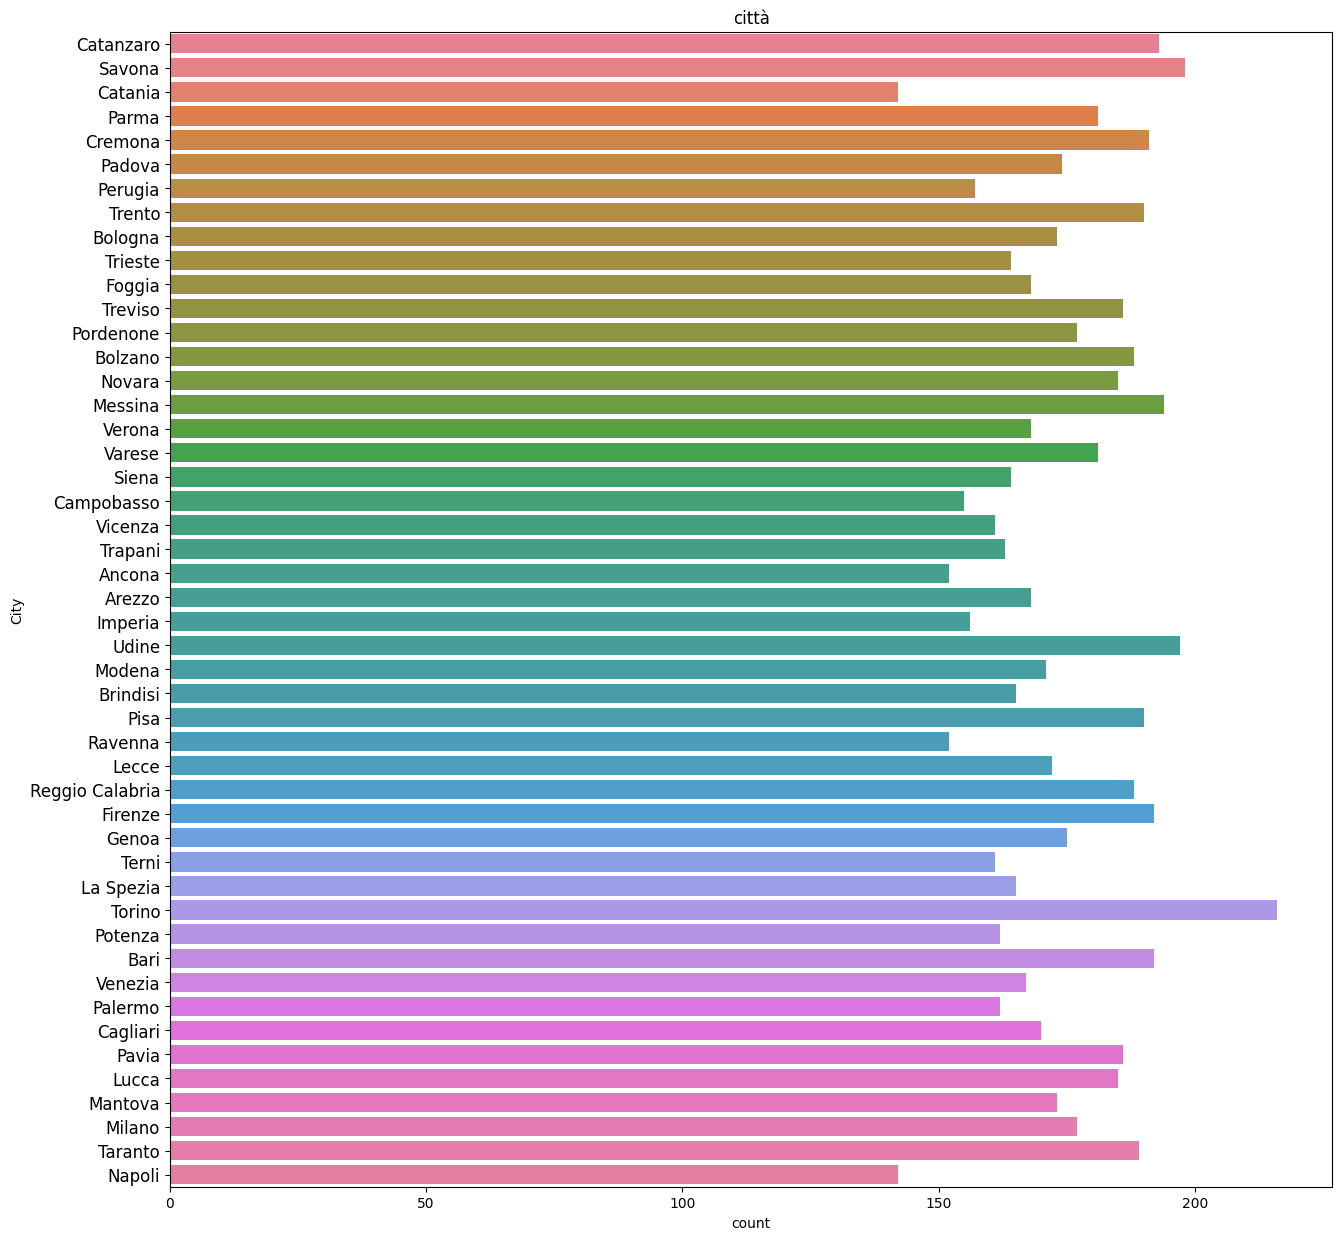

In [14]:
#controllo distribuzione dati
plt.figure(figsize=(15,15))
sns.countplot(y='City', data=città, hue ='City')
plt.yticks(fontsize=12)
plt.title('città')

In [15]:
#unisco latitudine e longitutdine al datset
dataset_v3['longitude'] = città['Longitude']
dataset_v3['latitude'] = città['Latitude']

La quota they\them è stata posta al 4% (dati pag 4)
 https://www.ipsos.com/sites/default/files/ct/news/documents/2023-05/Ipsos%20LGBT%2B%20Pride%202023%20Global%20Survey%20Report%20-%20rev.pdf

 aggiungo 259 (3% del dataset totale (dati precedenti+nuovi)) dati con gender = 3, gli altri dati sono stati copiati da esempi random scelti nel dataset con aggiunta di rumore gaussiano

In [16]:
df = dataset_v3.sample(n=259, random_state=42)

In [17]:
#generazione rumore gaussiano
mu, sigma = 0, 1  # Media e deviazione standard
noise = np.random.normal(mu, sigma, size=df.shape)
print(noise.shape)
df_noise = df.copy() + noise
df_noise['gender'] = 3

(259, 32)


In [18]:
longitude = df_noise['longitude']
latitude = df_noise['latitude']
df_noise.drop(['longitude','latitude'],axis=1)

age_o  attractive_important  sincere_important  \
4730  21.501167             19.509469          12.121246   
8168  26.048221             19.672019          15.584947   
2333  26.107881             17.383059          19.507793   
5426  31.080506             24.974473          21.812927   
5407  25.811276             19.705754          13.446280   
...         ...                   ...                ...   
4983  33.274455             20.455117          14.548350   
5559  27.068478             17.021022          17.742570   
8048  29.437768             49.645558           0.608031   
1261  28.218706             14.350795          20.402337   
4149  26.067436             27.485374          15.536583   

      intelligence_important  funny_important  ambition_important        age  \
4730               16.649346        18.469066           10.219183  26.146610   
8168               15.800811        17.820423           14.256187  24.471697   
2333               17.810255        17.407333           16.782247  29.148692   
5426               20.952015        21.661773            3.929509  22.884967   
5407               25.853848        18.425632            4.437196  30.083859   
...                      ...              ...                 ...        ...   
4983               30.433162        10.285099           14.086027  26.308564   
5559               27.744449        26.920245            3.962914  24.636340   
8048                9.901061        30.360169            0.739603  32.353788   
1261               16.174976        17.356932            9.490497  23.039012   
4149               28.228695         9.646082           11.657043  25.727651   

      attractive   sincere  intelligence  ...    gaming   clubbing    reading  \
4730    5.783276  7.524996     10.141519  ...  1.747439   9.059974   5.920451   
8168    6.838573  8.232656      8.339305  ...  8.524613   8.208391   7.104089   
2333    8.332997  9.507098      6.035907  ...  1.850000   7.109077   2.226611   
5426    3.885363  8.084500      8.054247  ...  6.195588  11.686111   7.919541   
5407    5.747058  7.992464     10.315362  ...  2.851366   6.384033   5.613502   
...          ...       ...           ...  ...       ...        ...        ...   
4983    6.982498  8.281165      8.893449  ...  0.920769   1.802245   8.981879   
5559    4.687816  9.674597      9.332326  ... -1.717238  -0.292032   8.724886   
8048    8.098286  8.788520     10.324860  ...  8.367857   5.945627   8.140489   
1261    3.775545  9.336113      5.028922  ...  2.728520   0.678857  10.883045   
4149    7.823370  8.744531      4.748583  ...  2.517646   4.423847   7.800129   

            tv   theater    movies   concerts      music   shopping      yoga  
4730  3.128924  2.316101  5.841342   7.059962  11.485132   5.776991  0.615941  
8168  6.454412  6.037249  9.032551   8.721762   6.679266  10.418520  3.176352  
2333  2.500423  6.586227  6.248782   6.411460   8.004296   3.992724  2.940568  
5426  5.757697  6.042616  8.104957   6.083417   5.003334   9.092986  4.753786  
5407  4.875666  5.630466  6.522347   8.095693   6.545368   7.840693  1.662147  
...        ...       ...       ...        ...        ...        ...       ...  
4983  4.041036  6.215668  9.580906  10.362064   9.041322   2.365143  3.288773  
5559  2.217670  5.222674  6.336993   4.646072   5.779572   0.974458  0.793838  
8048  5.093858  3.186748  6.378405   3.293487   7.439962   6.605523  5.329652  
1261  6.373781  8.173765  7.471947   7.462465   5.287277   5.190015  0.014321  
4149  7.311487  0.641422  6.349024   1.636385   0.992858  -0.515114  1.645490  

[259 rows x 30 columns]

In [19]:
#per simulare input user
for column in df_noise:
  df_noise[column] = np.round(df_noise[column])
df_noise['latitude'] = latitude
df_noise['longitude'] = longitude

In [20]:
dataset_v3 = pd.concat([dataset_v3, df_noise], ignore_index=True)
dataset_v3 = dataset_v3.sample(frac=1) #shuffle
dataset_v3.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8637 entries, 4612 to 1557
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_o                   8637 non-null   float64
 1   attractive_important    8637 non-null   float64
 2   sincere_important       8637 non-null   float64
 3   intelligence_important  8637 non-null   float64
 4   funny_important         8637 non-null   float64
 5   ambition_important      8637 non-null   float64
 6   age                     8637 non-null   float64
 7   attractive              8637 non-null   float64
 8   sincere                 8637 non-null   float64
 9   intelligence            8637 non-null   float64
 10  funny                   8637 non-null   float64
 11  ambition                8637 non-null   float64
 12  gender                  8637 non-null   float64
 13  sports                  8637 non-null   float64
 14  tvsports                8637 non-null   fl

**age**


*   age_flag: 1 -> sì, 0 -> no
*   age_radius: raggio generato tra [0,100], se flag=0 allora range =0, cioè età puntuale



In [21]:
#flag radius age
random.seed(43)
age_flags = []
age_flags = [random.randint(0,1) for x in range(0,len(list(dataset_v3['age_o'])))]
dataset_v3['age_flag'] = age_flags

#raggio età
age_radius = []
age_radius = [0 if a == 0 else np.random.randint(0, 100) for a in age_flags]
dataset_v3['age_radius'] = age_radius

In [22]:
#flag interessi in comune
random.seed(50)
shared_flags = []
shared_flags = [random.randint(0,1) for x in range(0,len(list(dataset_v3['age_o'])))]
dataset_v3['interest_flag'] = shared_flags

In [23]:
partner_interests = []
for column in interests:
 column_name = column + '_partner'
 partner_interests.append(column_name)
 column_partner = [dataset_v3[column].iloc[idx] if x == 1 else np.random.randint(1, 10) for idx, x in enumerate(shared_flags)]
 dataset_v3[column_name] = column_partner

**range distanza (km)**

In [24]:
#generata a salti di 10km
random.seed(55)
distance = [random.randint(0,10)*10 for x in range(0,len(list(dataset_v3['longitude'])))]
dataset_v3['distance_km'] = distance

**codifica testuale genere user**


*   he,him -> 1
*   she,her -> 2
*   they,them -> 3



In [25]:
gender_text = []
for i in range (0,len(list(dataset_v3['gender'].values))):
  if dataset_v3['gender'].loc[dataset_v3.index[i]] == 1.:
    gender_text.append("he,him")
  if dataset_v3['gender'].loc[dataset_v3.index[i]] == 2.:
    gender_text.append("she,her")
  if dataset_v3['gender'].loc[dataset_v3.index[i]] == 3.:
    gender_text.append("they,them")

In [26]:
dataset_v3['gender_text'] = gender_text

**genere partner cercato**

In [27]:
#recupero i dati testuali generati da chatgpt per il genere del partner cercato
df= pd.read_csv("updated_gender_text.csv")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8637 entries, 0 to 8636
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender_partner_text  8637 non-null   object
dtypes: object(1)
memory usage: 67.6+ KB


In [28]:
dataset_v3['gender_partner_text'] = df['gender_partner_text']
#dataset_v3.info(verbose=True)

In [29]:
#separo i pronomi
gender_partner_text = [x.split(",") for x in list(dataset_v3['gender_partner_text'].values)]

In [30]:
#codifico i pronomi con un array 3d
gender_partner = []
gender_partner_him = []
gender_partner_her = []
gender_partner_them = []
for i in range (0,len(gender_partner_text)):
  labels = []
  if 'him' in gender_partner_text[i]:
    labels.append(1.)
    gender_partner_him.append(1.)
  if 'him' not in gender_partner_text[i]:
   labels.append(0.)
   gender_partner_him.append(0.)
  if 'her' in gender_partner_text[i]:
    labels.append(1.)
    gender_partner_her.append(1.)
  if 'her' not in gender_partner_text[i]:
    labels.append(0.)
    gender_partner_her.append(0.)
  if 'them' in gender_partner_text[i]:
    labels.append(1.)
    gender_partner_them.append(1.)
  if 'them' not in gender_partner_text[i]:
    labels.append(0.)
    gender_partner_them.append(0.)

  gender_partner.append(labels)

dataset_v3['gender_partner'] = gender_partner
dataset_v3['gender_partner_him'] = gender_partner_him
dataset_v3['gender_partner_her'] = gender_partner_her
dataset_v3['gender_partner_them'] = gender_partner_them


In [31]:
dataset_v3.info(verbose=True)
dataset_v3.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 8637 entries, 4612 to 1557
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_o                   8637 non-null   float64
 1   attractive_important    8637 non-null   float64
 2   sincere_important       8637 non-null   float64
 3   intelligence_important  8637 non-null   float64
 4   funny_important         8637 non-null   float64
 5   ambition_important      8637 non-null   float64
 6   age                     8637 non-null   float64
 7   attractive              8637 non-null   float64
 8   sincere                 8637 non-null   float64
 9   intelligence            8637 non-null   float64
 10  funny                   8637 non-null   float64
 11  ambition                8637 non-null   float64
 12  gender                  8637 non-null   float64
 13  sports                  8637 non-null   float64
 14  tvsports                8637 non-null   fl

age_o  attractive_important  sincere_important  \
count  8637.000000           8637.000000        8637.000000   
mean     26.376520             22.474810          17.445482   
std       3.538702             12.527917           7.032045   
min      18.000000              0.000000          -2.000000   
25%      24.000000             15.000000          15.000000   
50%      26.000000             20.000000          18.750000   
75%      28.000000             25.000000          20.000000   
max      55.000000            100.000000          60.000000   

       intelligence_important  funny_important  ambition_important  \
count             8637.000000      8637.000000         8637.000000   
mean                20.253945        17.489456           10.677520   
std                  6.741568         6.064260            6.084629   
min                 -1.000000         0.000000           -2.000000   
25%                 17.390000        15.000000            5.000000   
50%                 20.000000        18.000000           10.000000   
75%                 23.260000        20.000000           15.000000   
max                 51.000000        50.000000           53.000000   

               age   attractive      sincere  intelligence  ...  \
count  8637.000000  8637.000000  8637.000000   8637.000000  ...   
mean     26.363205     7.076415     8.306472      7.705338  ...   
std       3.551409     1.407466     1.419190      1.567276  ...   
min      18.000000     1.000000     1.000000      1.000000  ...   
25%      24.000000     6.000000     8.000000      7.000000  ...   
50%      26.000000     7.000000     9.000000      8.000000  ...   
75%      28.000000     8.000000     9.000000      9.000000  ...   
max      55.000000    11.000000    13.000000     14.000000  ...   

       theater_partner  movies_partner  concerts_partner  music_partner  \
count      8637.000000     8637.000000       8637.000000    8637.000000   
mean          5.874841        6.453630          5.886766       6.420980   
std           2.568778        2.636647          2.545766       2.651202   
min           0.000000        0.000000          0.000000       1.000000   
25%           4.000000        5.000000          4.000000       5.000000   
50%           6.000000        7.000000          6.000000       7.000000   
75%           8.000000        9.000000          8.000000       9.000000   
max          12.000000       12.000000         12.000000      12.000000   

       shopping_partner  yoga_partner  distance_km  gender_partner_him  \
count       8637.000000   8637.000000  8637.000000         8637.000000   
mean           5.334607      4.630890    49.967581            0.483617   
std            2.606219      2.680779    31.430668            0.499760   
min            1.000000     -1.000000     0.000000            0.000000   
25%            3.000000      2.000000    20.000000            0.000000   
50%            5.000000      4.000000    50.000000            0.000000   
75%            7.000000      7.000000    80.000000            1.000000   
max           12.000000     11.000000   100.000000            1.000000   

       gender_partner_her  gender_partner_them  
count         8637.000000          8637.000000  
mean             0.524719             0.011578  
std              0.499417             0.106983  
min              0.000000             0.000000  
25%              0.000000             0.000000  
50%              1.000000             0.000000  
75%              1.000000             0.000000  
max              1.000000             1.000000  

[8 rows x 56 columns]

#Rescaling features#

In [32]:
dataset_v4 = dataset_v3.copy()

partner_attributes:


*   rescaling features [0,20] -> [1,5]



In [33]:
partner_attributes.remove('age_o')

In [34]:
scaler = MinMaxScaler(feature_range=(1,5))

In [35]:
dataset_v4[partner_attributes] = scaler.fit_transform(dataset_v4[partner_attributes])

In [36]:
#uniformo i dati ai dati forniti dagli user
dataset_v4[partner_attributes] = np.round(dataset_v4[partner_attributes])

In [37]:
for column in partner_attributes:
  print(column,set(dataset_v4[column]))

attractive_important {1.0, 2.0, 3.0, 4.0, 5.0}
sincere_important {1.0, 2.0, 3.0, 4.0, 5.0}
intelligence_important {1.0, 2.0, 3.0, 4.0, 5.0}
funny_important {1.0, 2.0, 3.0, 4.0, 5.0}
ambition_important {1.0, 2.0, 3.0, 5.0}


In [38]:
#check fondo scala
count_zeros = (dataset_v4[partner_attributes] == 0).sum()
print(count_zeros)

attractive_important      0
sincere_important         0
intelligence_important    0
funny_important           0
ambition_important        0
dtype: int64


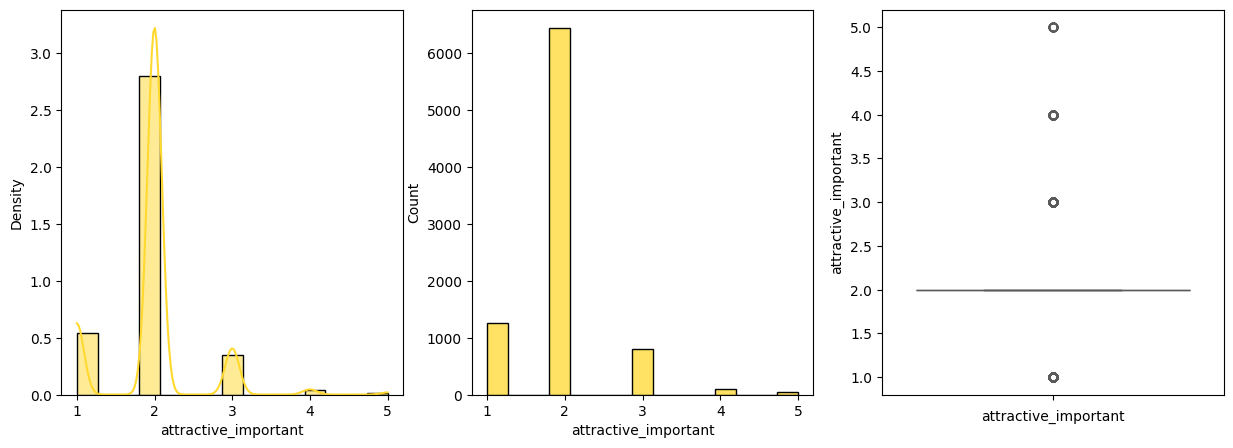

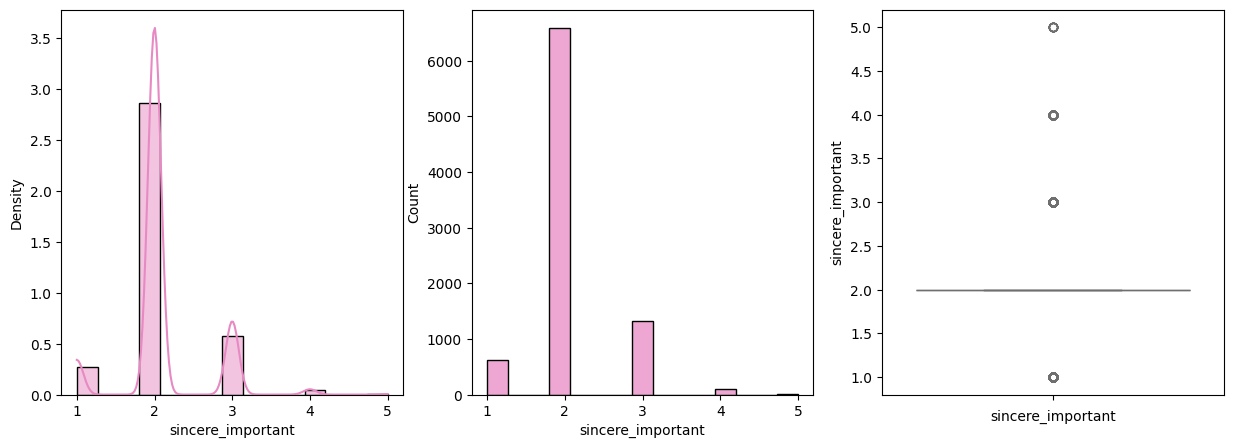

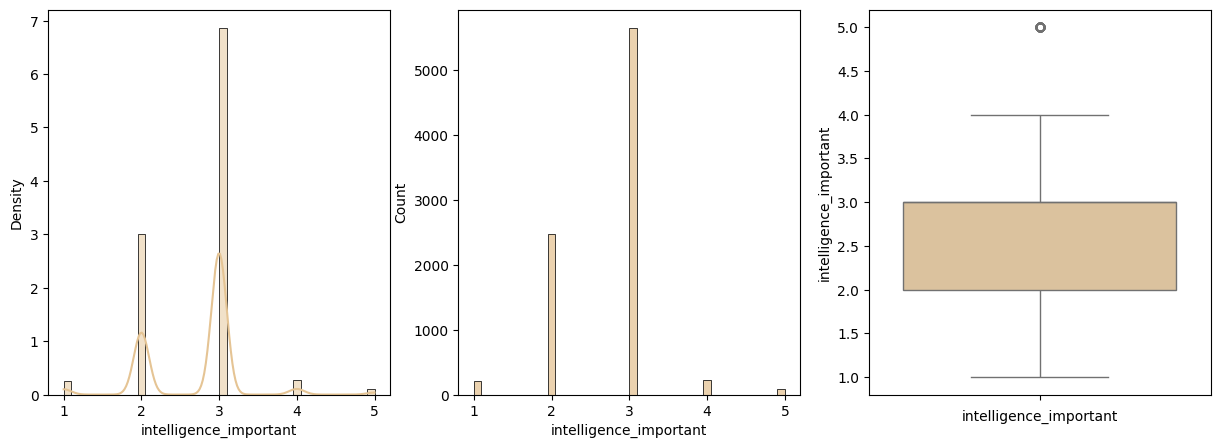

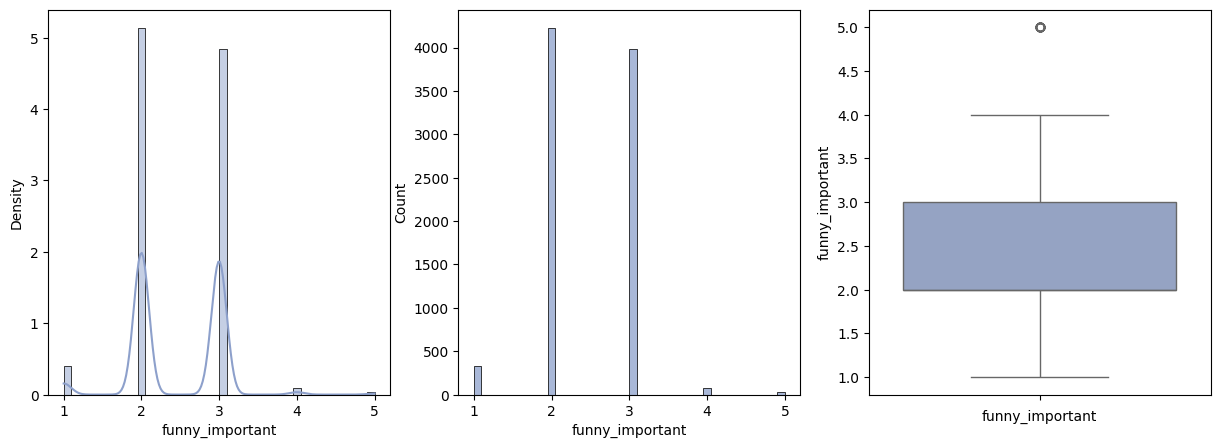

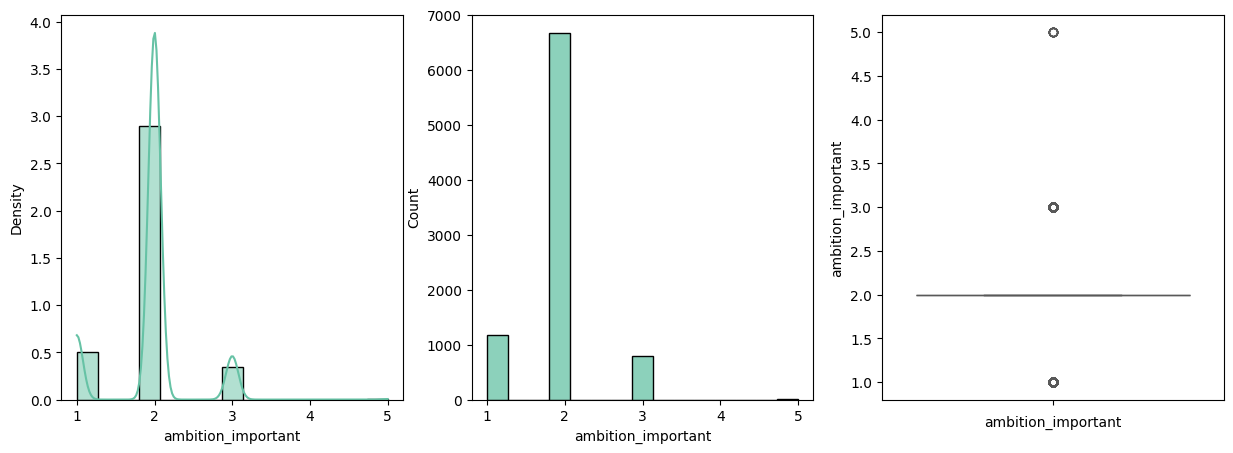

In [39]:
#controllo la nuova distribuzione dei dati
for column in partner_attributes:
    grafici(dataset_v4[column])

In [40]:
dataset_v4[partner_attributes].max()
dataset_v4[partner_attributes].min()
dataset_v4[partner_attributes].describe()

attractive_important  sincere_important  intelligence_important  \
count           8637.000000        8637.000000             8637.000000   
mean               1.983096           2.105824                2.709506   
std                0.565891           0.517556                0.602810   
min                1.000000           1.000000                1.000000   
25%                2.000000           2.000000                2.000000   
50%                2.000000           2.000000                3.000000   
75%                2.000000           2.000000                3.000000   
max                5.000000           5.000000                5.000000   

       funny_important  ambition_important  
count      8637.000000         8637.000000  
mean          2.449809            1.959708  
std           0.601786            0.485307  
min           1.000000            1.000000  
25%           2.000000            2.000000  
50%           2.000000            2.000000  
75%           3.000000            2.000000  
max           5.000000            5.000000

<Axes: title={'center': 'Correlation Matrix'}>

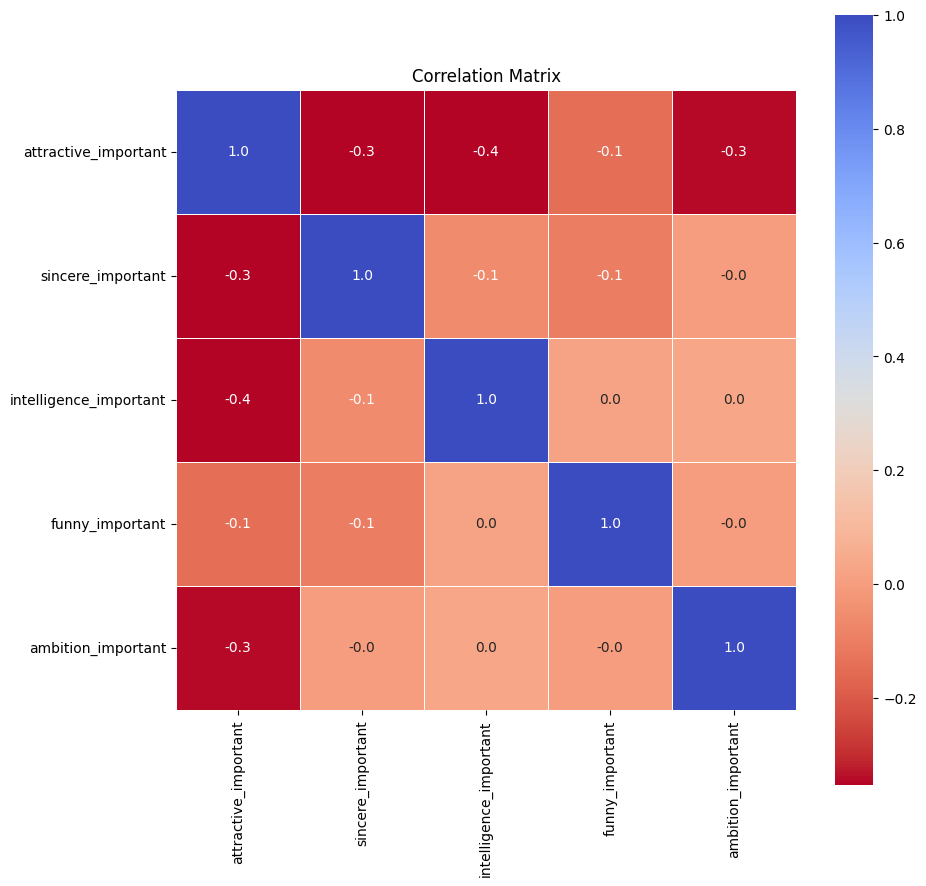

In [41]:
#matrice di correlazione ridotta
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(data=dataset_v4[partner_attributes].corr(), cmap = 'coolwarm_r',annot=True,fmt=".1f", linewidth=.5,square=True)

interests:


*   riduzione features, media dei valori per ogni riga:


1.   museums, art -> arts
2.   concerts, music -> music




---


*   rescaling features [0,10] -> [1,10]
    i valori sono stati accorpati nella colonna 1 perchè statisticamente in numero non rilevante, pochi valori uno se tanti valori zero e viceversa.
*   gaming e reading presentano pochi valori sopra la 10, sono stati accorpati nel valore 10     



In [42]:
#features reduction
dataset_v4['art'] = np.round((dataset_v4['museums'] + dataset_v4['art'])/2)
dataset_v4['music'] = np.round((dataset_v4['concerts'] + dataset_v4['music'])/2)

In [43]:
#drop colonne high variance
dataset_v4.drop(['museums','concerts'],axis=1)

age_o  attractive_important  sincere_important  intelligence_important  \
4612   32.0                   1.0                4.0                     2.0   
5086   25.0                   2.0                2.0                     2.0   
427    24.0                   2.0                3.0                     3.0   
1268   32.0                   2.0                2.0                     2.0   
7127   27.0                   2.0                2.0                     3.0   
...     ...                   ...                ...                     ...   
7156   25.0                   2.0                2.0                     3.0   
3212   23.0                   2.0                2.0                     2.0   
2164   27.0                   2.0                2.0                     3.0   
1426   27.0                   2.0                3.0                     3.0   
1557   30.0                   1.0                2.0                     4.0   

      funny_important  ambition_important   age  attractive  sincere  \
4612              2.0                 1.0  29.0         7.0      9.0   
5086              3.0                 3.0  26.0         7.0      7.0   
427               3.0                 2.0  25.0         8.0      9.0   
1268              2.0                 2.0  23.0         5.0      8.0   
7127              3.0                 2.0  30.0         7.0     10.0   
...               ...                 ...   ...         ...      ...   
7156              2.0                 2.0  31.0         4.0      8.0   
3212              2.0                 2.0  32.0         8.0     10.0   
2164              3.0                 2.0  23.0         7.0      9.0   
1426              2.0                 2.0  28.0        10.0     10.0   
1557              2.0                 2.0  22.0         4.0      7.0   

      intelligence  ...  music_partner  shopping_partner  yoga_partner  \
4612           8.0  ...            7.0               9.0           8.0   
5086           8.0  ...            9.0               9.0           5.0   
427            9.0  ...            7.0               8.0           3.0   
1268           5.0  ...            3.0               3.0           6.0   
7127           9.0  ...            4.0               4.0           3.0   
...            ...  ...            ...               ...           ...   
7156           2.0  ...            8.0               9.0           5.0   
3212           8.0  ...            4.0               1.0           8.0   
2164           7.0  ...            9.0               5.0           1.0   
1426          10.0  ...           10.0               8.0           5.0   
1557           3.0  ...            8.0               5.0           3.0   

      distance_km  gender_text  gender_partner_text   gender_partner  \
4612           10      she,her              she,her  [0.0, 1.0, 0.0]   
5086           30      she,her              she,her  [0.0, 1.0, 0.0]   
427            20      she,her               he,him  [1.0, 0.0, 0.0]   
1268           40      she,her               he,him  [1.0, 0.0, 0.0]   
7127           10       he,him               he,him  [1.0, 0.0, 0.0]   
...           ...          ...                  ...              ...   
7156           50       he,him               he,him  [1.0, 0.0, 0.0]   
3212           50       he,him              she,her  [0.0, 1.0, 0.0]   
2164           40       he,him       he.him,she,her  [0.0, 1.0, 0.0]   
1426           60       he,him              she,her  [0.0, 1.0, 0.0]   
1557           90       he,him               he,him  [1.0, 0.0, 0.0]   

      gender_partner_him  gender_partner_her  gender_partner_them  
4612                 0.0                 1.0                  0.0  
5086                 0.0                 1.0                  0.0  
427                  1.0                 0.0                  0.0  
1268                 1.0                 0.0                  0.0  
7127                 1.0                 0.0                  0.0  
...               

In [44]:
interests.remove('museums')
interests.remove('concerts')

In [45]:
#necessario altrimenti la distribuzione è strana
scaler = MinMaxScaler(feature_range=(1,10))

In [46]:
dataset_v4[interests] = scaler.fit_transform(dataset_v4[interests])

In [47]:
#uniformo i dati ai dati forniti dagli user
dataset_v4[interests] = np.round(dataset_v4[interests])

In [48]:
for column in interests:
  print(column,set(dataset_v4[column]))

sports {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
tvsports {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
exercise {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
dining {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
art {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
hiking {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
gaming {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
clubbing {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
reading {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
tv {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
theater {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
movies {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
music {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
shopping {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
yoga {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}


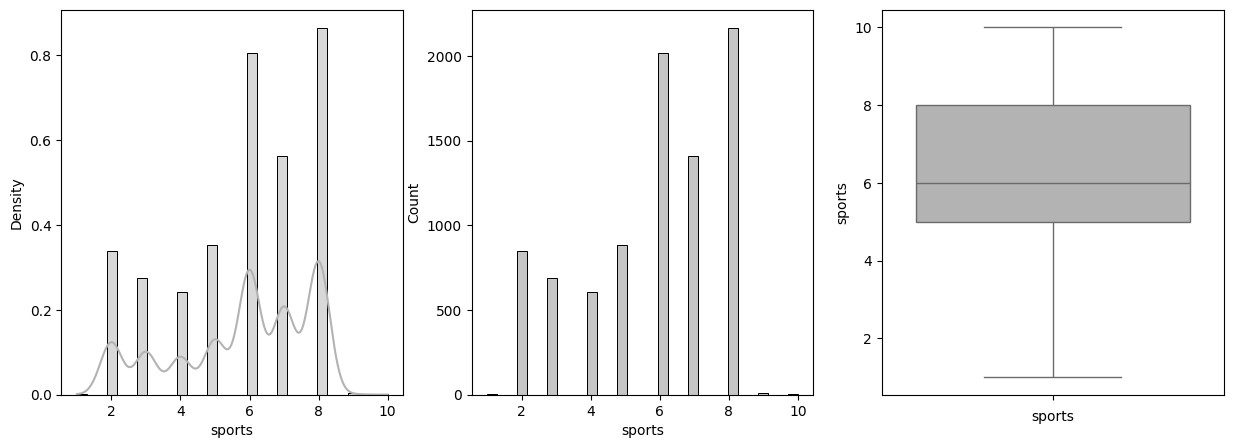

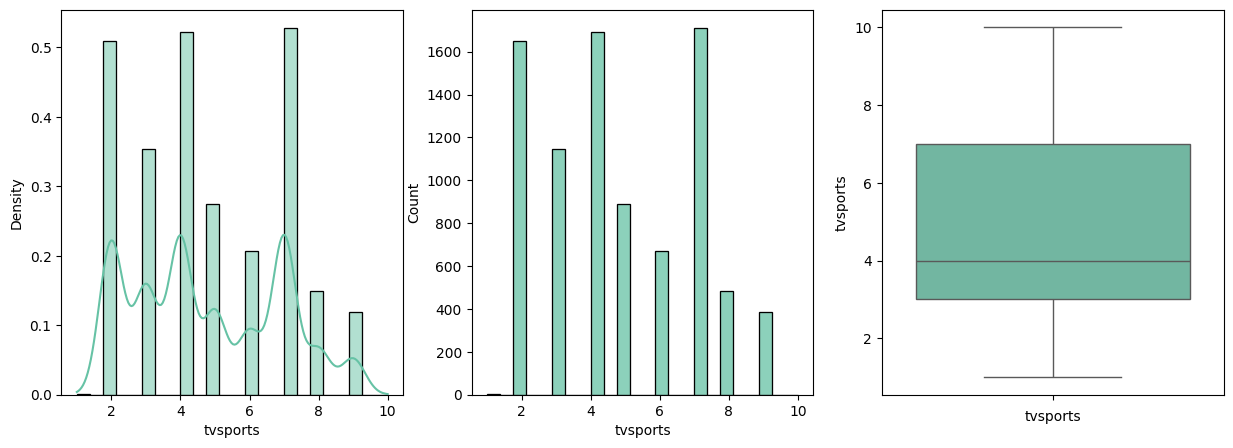

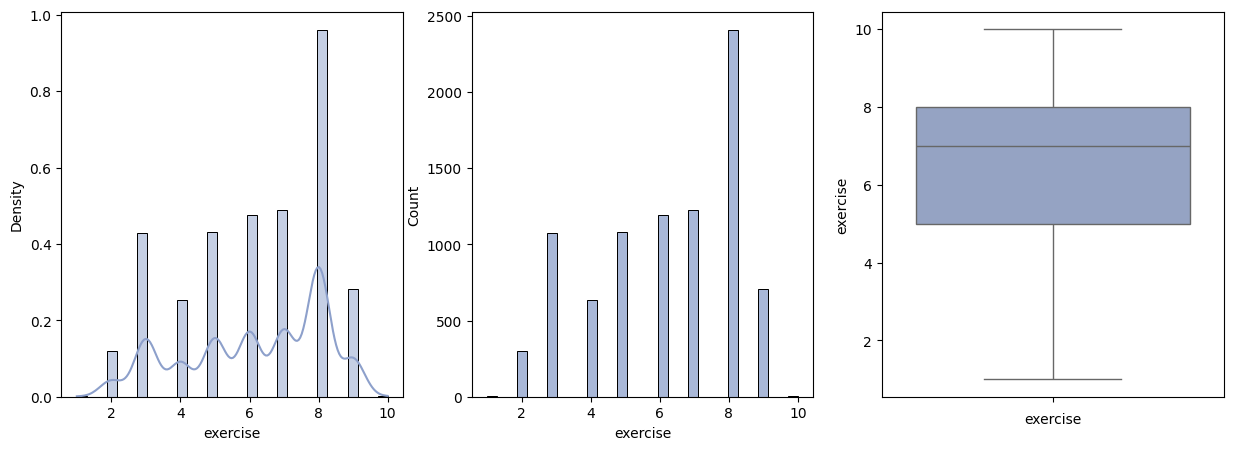

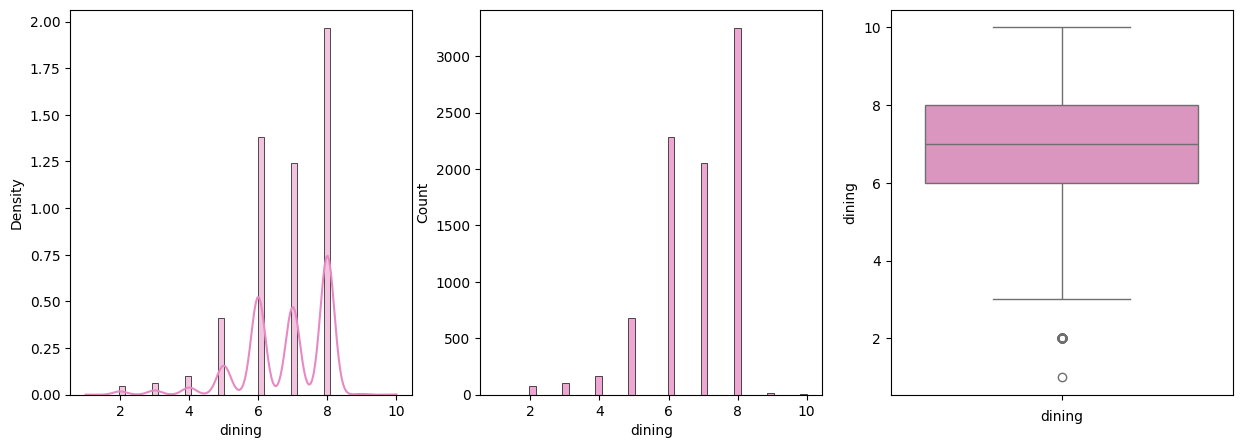

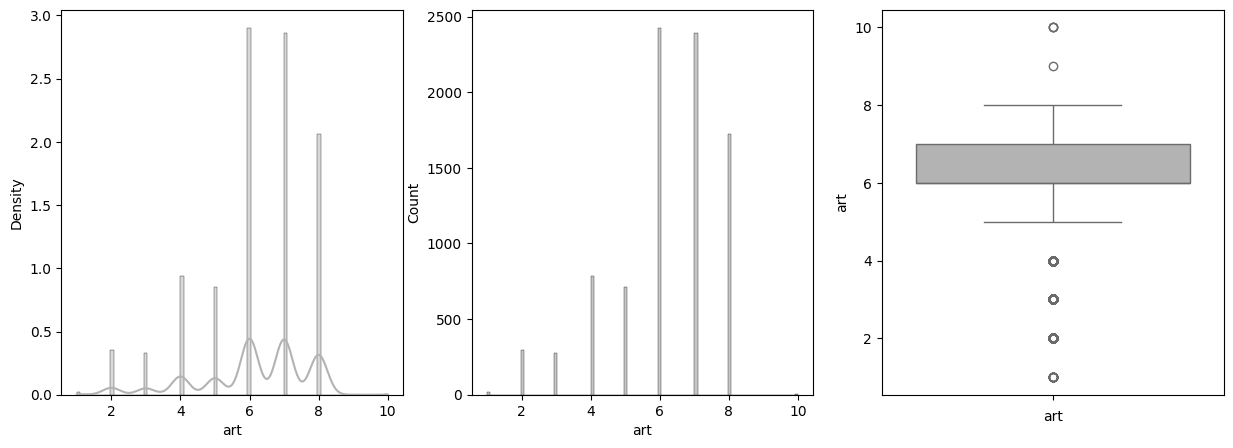

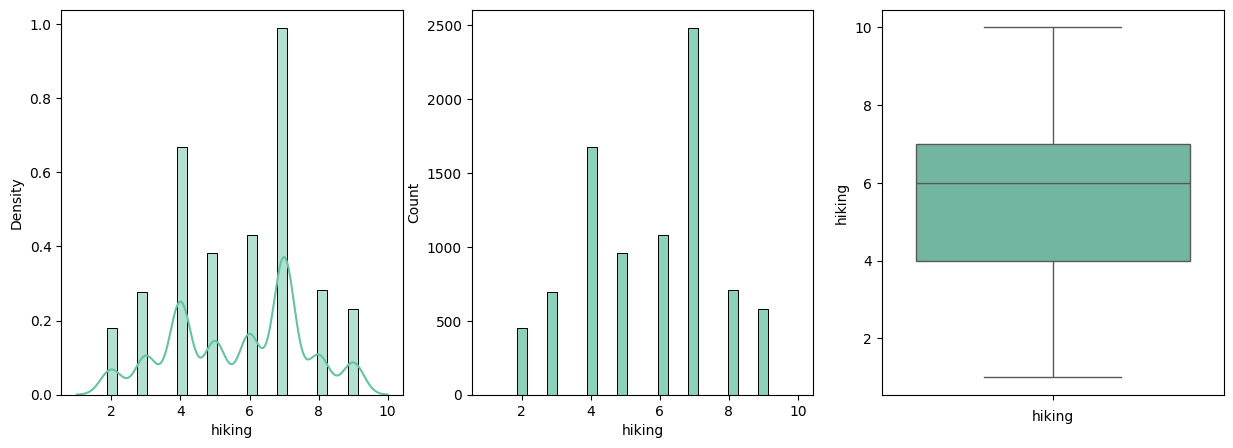

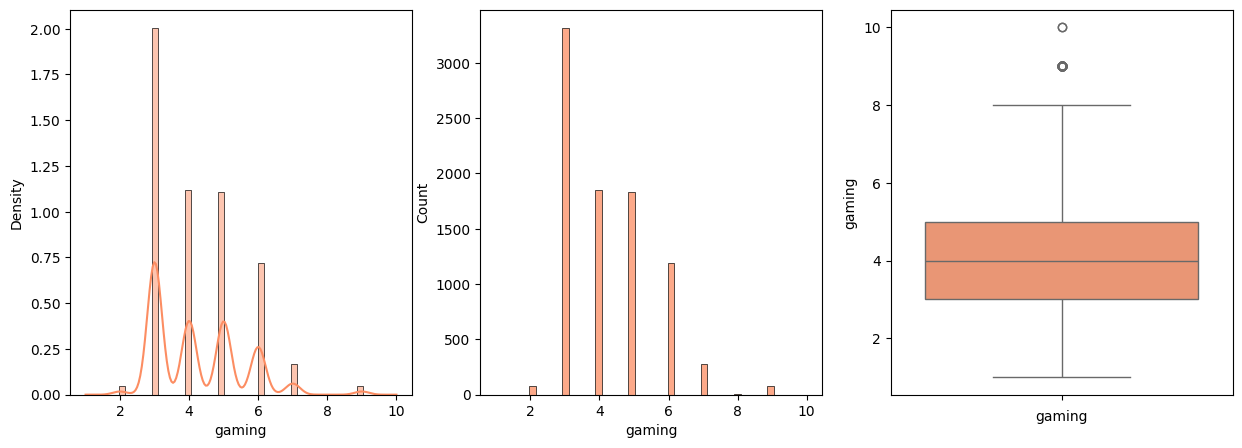

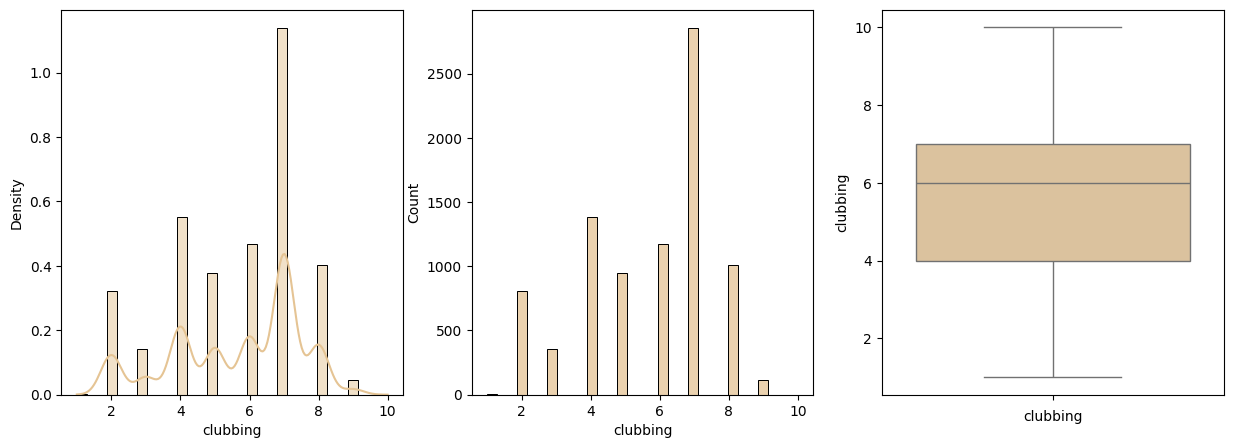

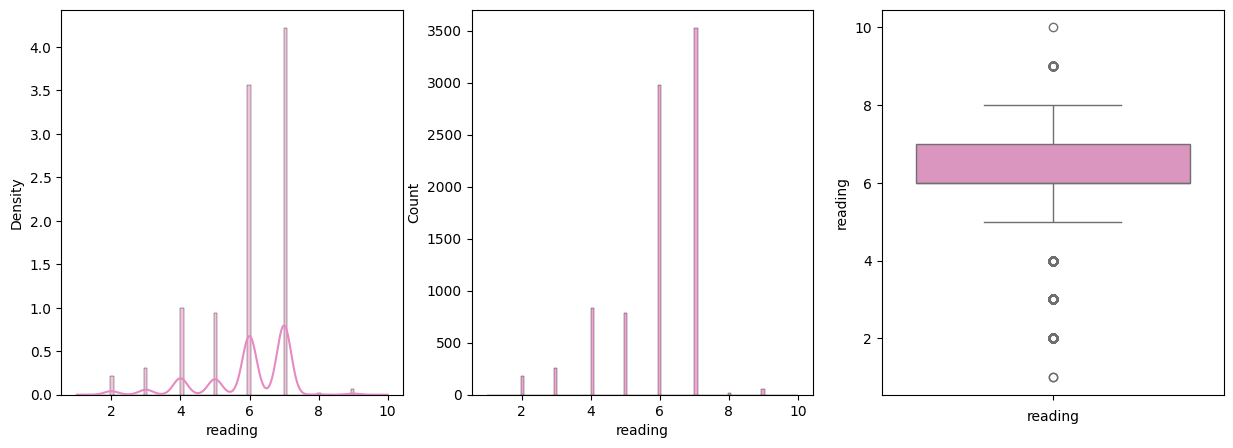

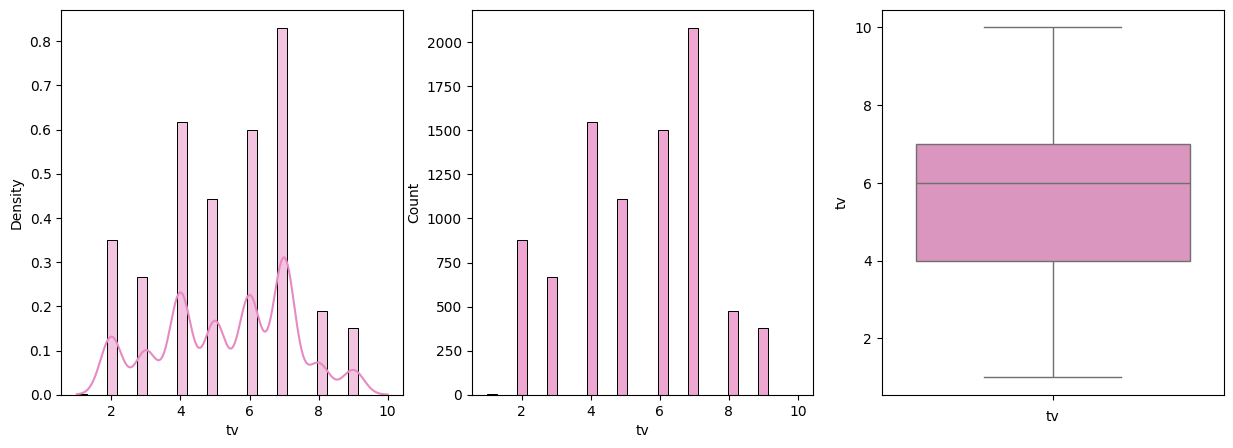

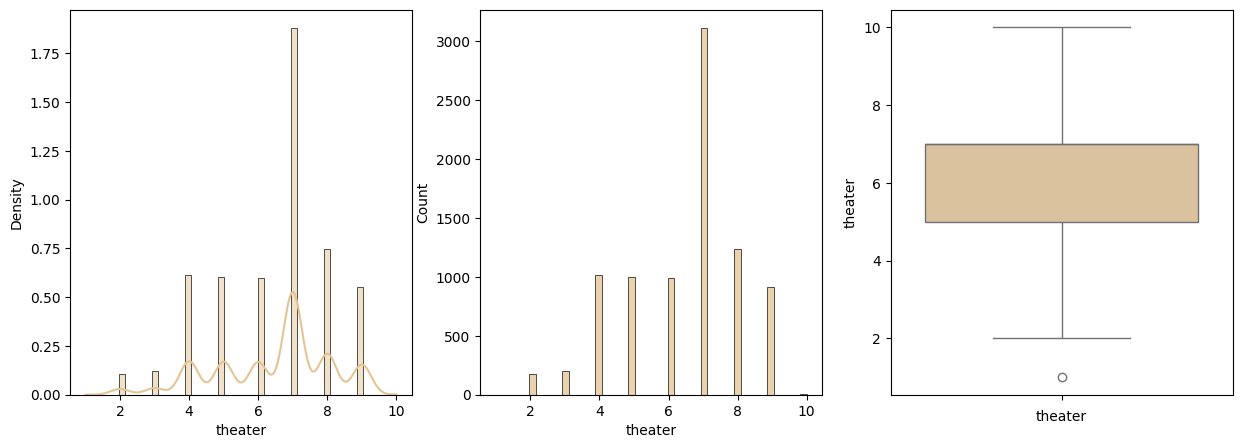

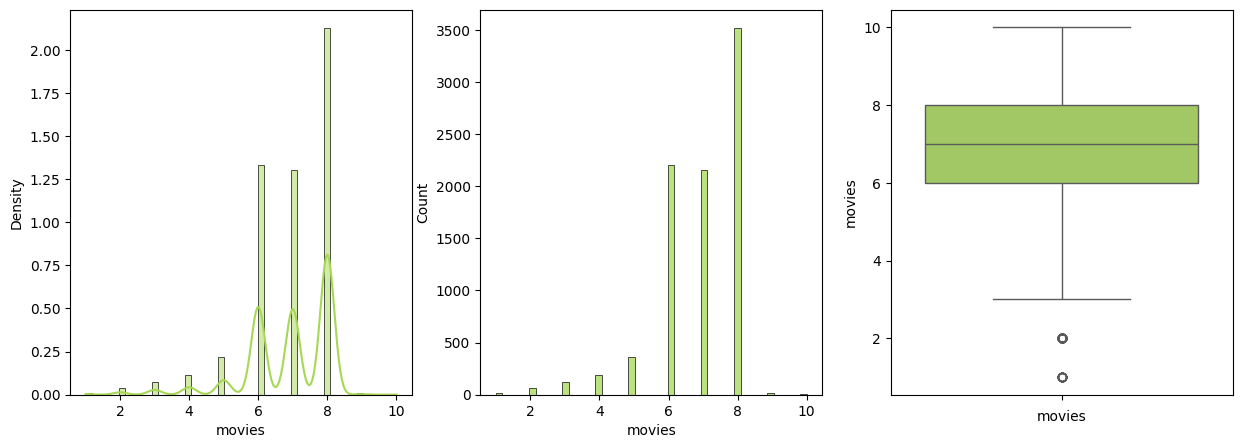

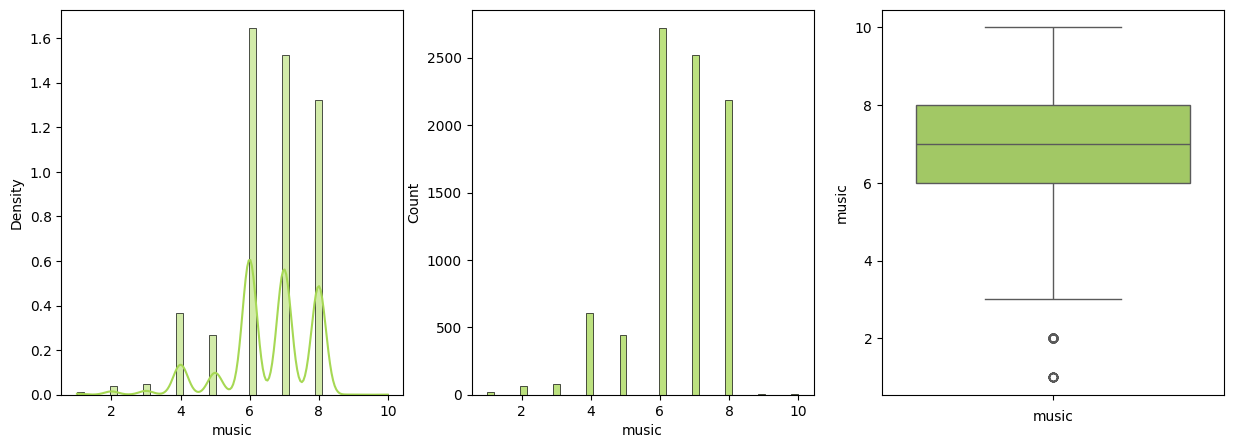

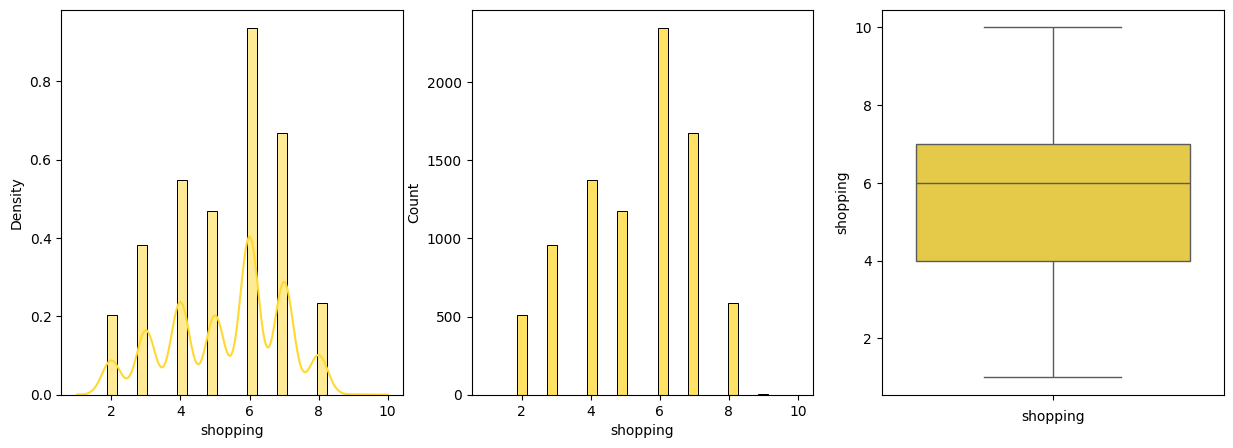

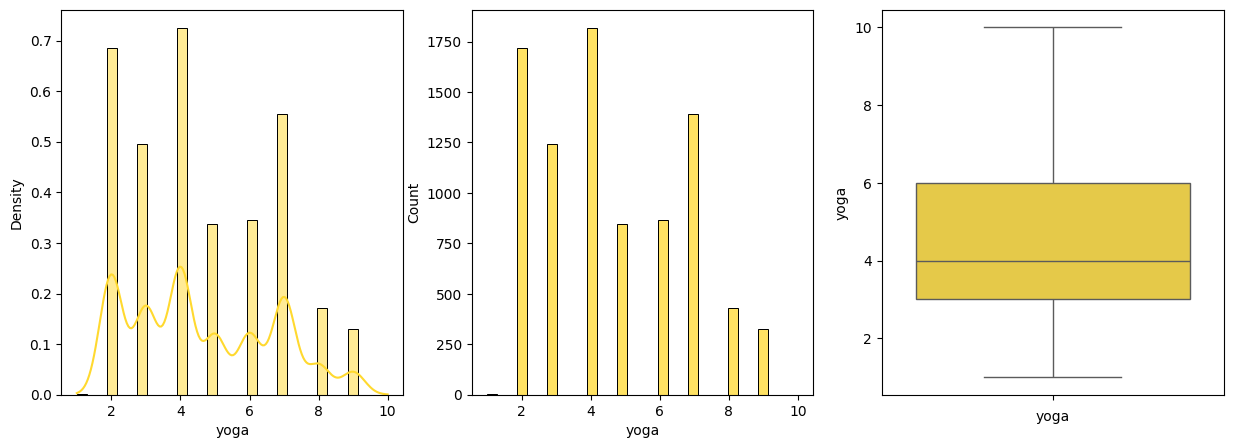

In [49]:
for column in interests:
    grafici(dataset_v4[column])

In [50]:
dataset_v4[interests].max()
dataset_v4[interests].min()
dataset_v4[interests].describe()

sports     tvsports     exercise       dining          art  \
count  8637.000000  8637.000000  8637.000000  8637.000000  8637.000000   
mean      5.789626     4.785689     6.162209     6.810351     6.169388   
std       1.954933     2.121984     2.021874     1.233194     1.546380   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       5.000000     3.000000     5.000000     6.000000     6.000000   
50%       6.000000     4.000000     7.000000     7.000000     6.000000   
75%       8.000000     7.000000     8.000000     8.000000     7.000000   
max      10.000000    10.000000    10.000000    10.000000    10.000000   

            hiking       gaming     clubbing      reading           tv  \
count  8637.000000  8637.000000  8637.000000  8637.000000  8637.000000   
mean      5.702675     4.232720     5.675698     5.974644     5.354869   
std       1.894156     1.293902     1.852687     1.247389     1.901443   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       4.000000     3.000000     4.000000     6.000000     4.000000   
50%       6.000000     4.000000     6.000000     6.000000     6.000000   
75%       7.000000     5.000000     7.000000     7.000000     7.000000   
max      10.000000    10.000000    10.000000    10.000000    10.000000   

           theater       movies        music     shopping         yoga  
count  8637.000000  8637.000000  8637.000000  8637.000000  8637.000000  
mean      6.464282     6.904018     6.540813     5.309367     4.627533  
std       1.671569     1.223299     1.267438     1.647186     2.058680  
min       1.000000     1.000000     1.000000     1.000000     1.000000  
25%       5.000000     6.000000     6.000000     4.000000     3.000000  
50%       7.000000     7.000000     7.000000     6.000000     4.000000  
75%       7.000000     8.000000     8.000000     7.000000     6.000000  
max      10.000000    10.000000    10.000000    10.000000    10.000000

<Axes: title={'center': 'Correlation Matrix'}>

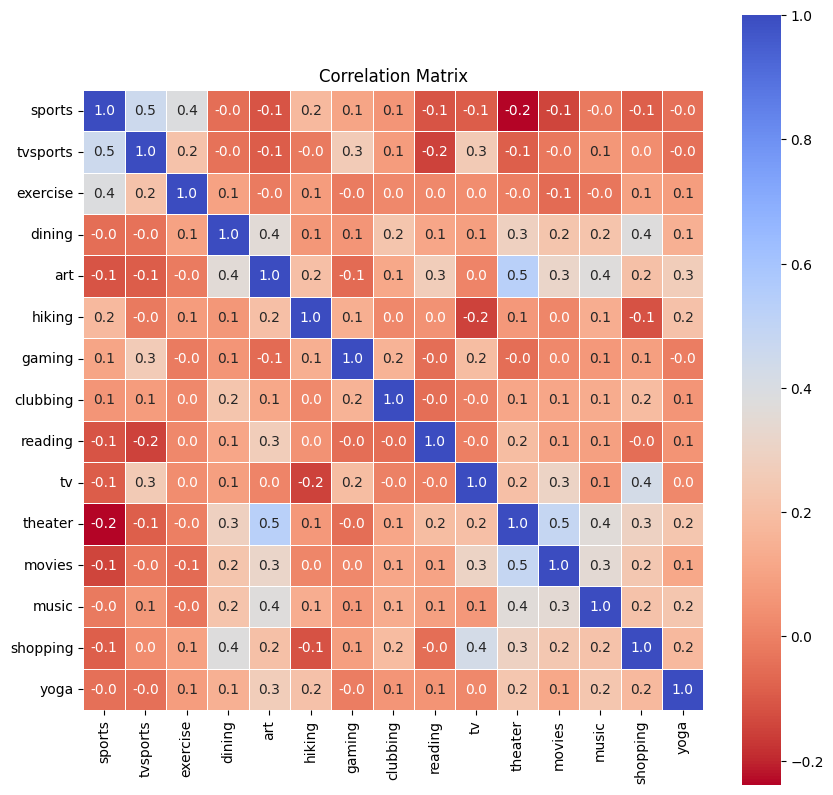

In [51]:
#matrice di correlazione ridotta
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(data=dataset_v4[interests].corr(), cmap = 'coolwarm_r',annot=True,fmt=".1f", linewidth=.5,square=True)

**self_description**

Modifico l'intervallo [0,12] -> [1,10]

In [52]:
self_description.remove('age')
self_description.remove('gender')

In [53]:
#necessario altrimenti la distribuzione è strana
scaler = MinMaxScaler(feature_range=(1,10))

In [54]:
dataset_v4[self_description] = scaler.fit_transform(dataset_v4[self_description])

In [55]:
#uniformo i dati ai dati forniti dagli user
dataset_v4[self_description] = np.round(dataset_v4[self_description])

In [56]:
for column in self_description:
  print(column,set(dataset_v4[column]))

attractive {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
sincere {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
intelligence {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
funny {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
ambition {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}


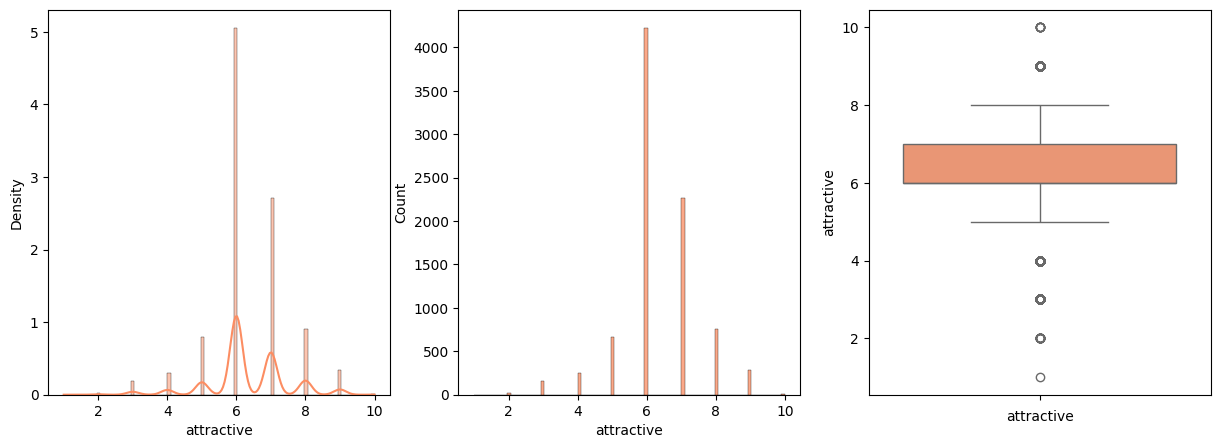

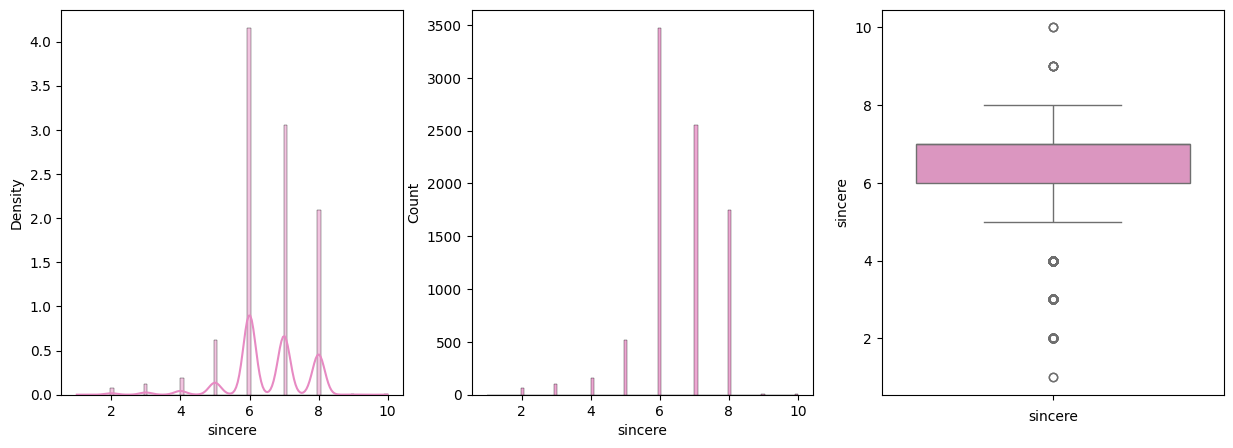

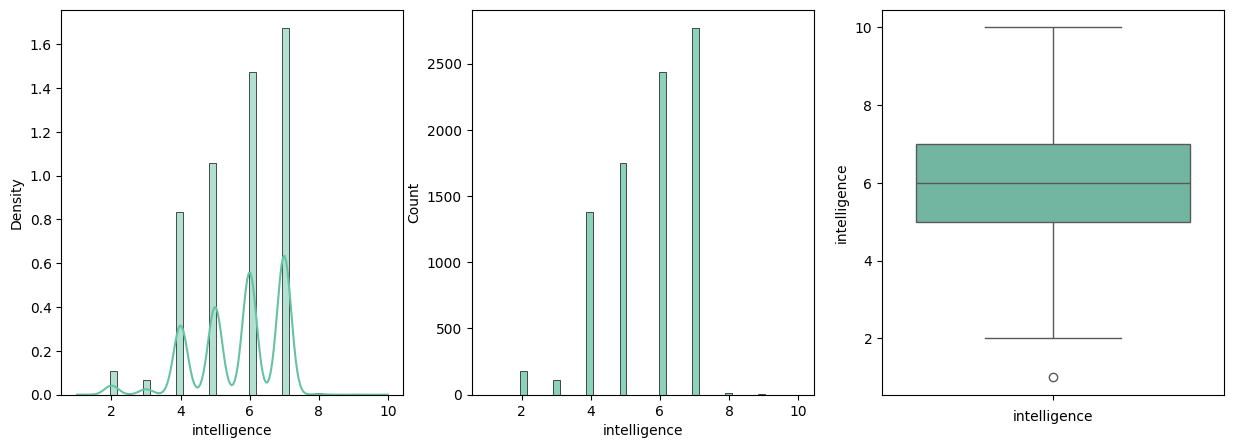

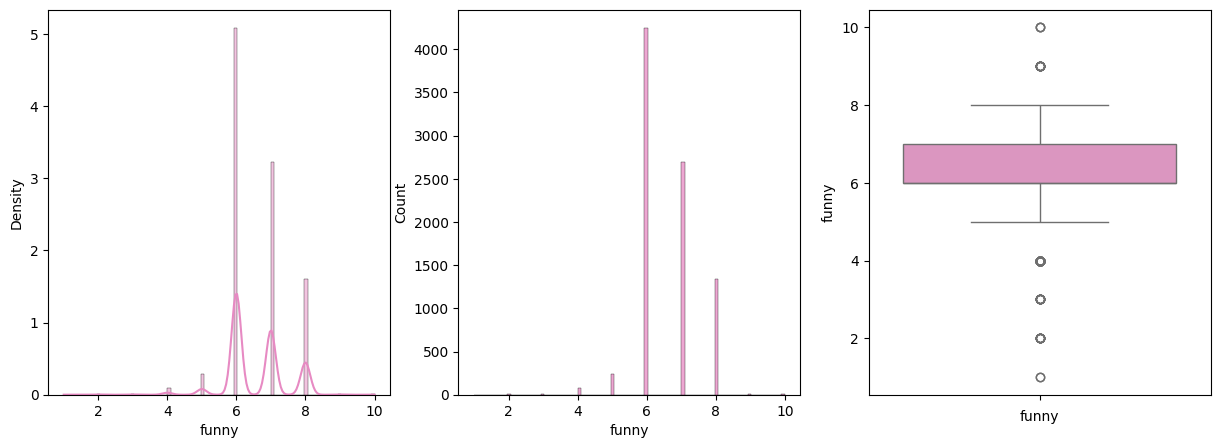

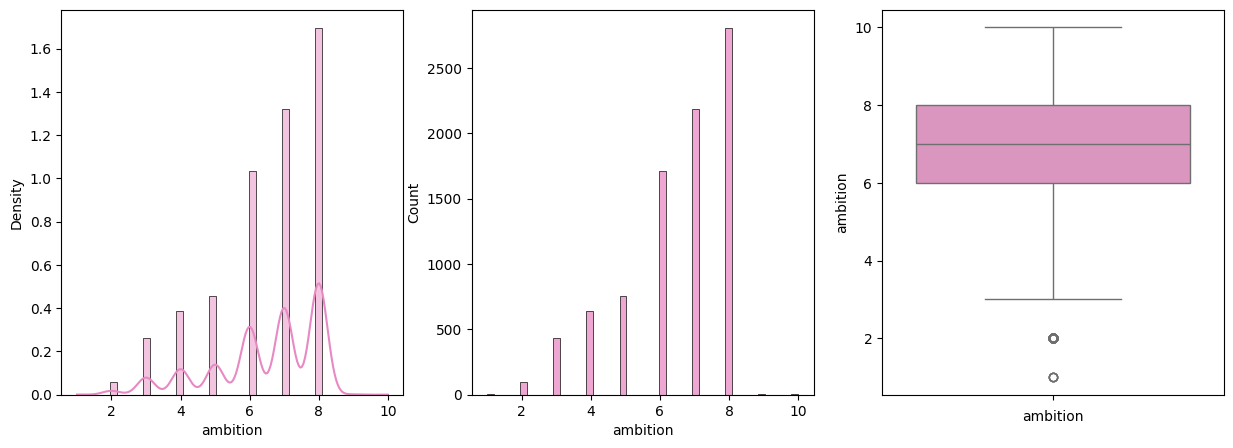

In [57]:
for column in self_description:
    grafici(dataset_v4[column])

In [58]:
dataset_v4[self_description].max()
dataset_v4[self_description].min()
dataset_v4[self_description].describe()

attractive      sincere  intelligence        funny     ambition
count  8637.000000  8637.000000   8637.000000  8637.000000  8637.000000
mean      6.336691     6.544055      5.680792     6.571958     6.472386
std       1.099755     1.087450      1.233175     0.851838     1.539155
min       1.000000     1.000000      1.000000     1.000000     1.000000
25%       6.000000     6.000000      5.000000     6.000000     6.000000
50%       6.000000     7.000000      6.000000     6.000000     7.000000
75%       7.000000     7.000000      7.000000     7.000000     8.000000
max      10.000000    10.000000     10.000000    10.000000    10.000000

<Axes: title={'center': 'Correlation Matrix'}>

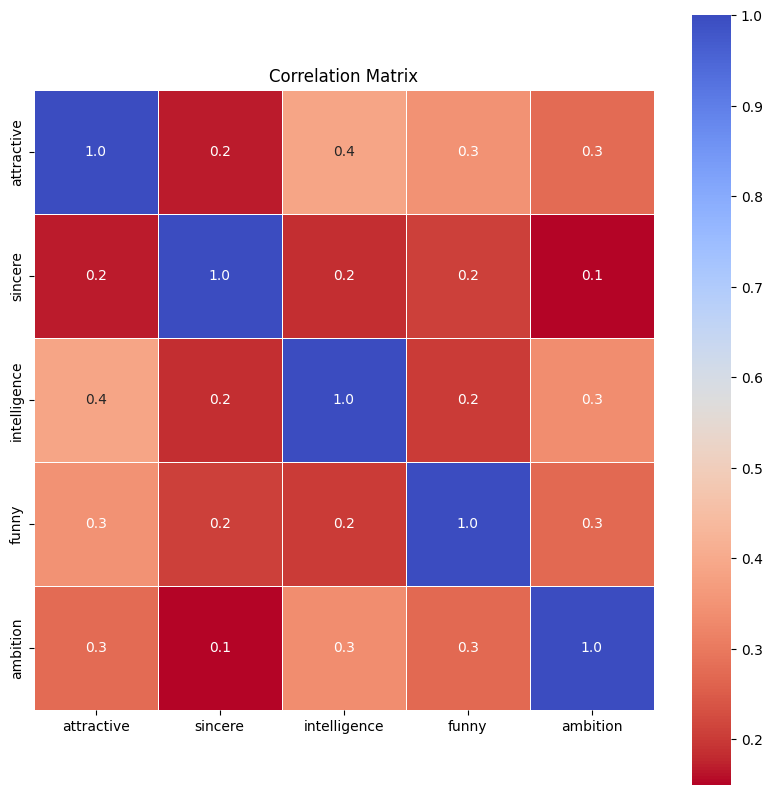

In [59]:
#matrice di correlazione ridotta
#matrice di correlazione ridotta
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(data=dataset_v4[self_description].corr(), cmap = 'coolwarm_r',annot=True,fmt=".1f", linewidth=.5,square=True)

Check età ed età partner (+18)

In [60]:
dataset_v4['age'].min()
dataset_v4['age_o'].min()

18.0

**interessi cercati nel partner**
stessa scaletta variabili interests

In [61]:
#features reduction
dataset_v4['art_partner'] = np.round((dataset_v4['museums_partner'] + dataset_v4['art_partner'])/2)
dataset_v4['music_partner'] = np.round((dataset_v4['concerts_partner'] + dataset_v4['music_partner'])/2)

In [62]:
#drop colonne high variance
dataset_v4.drop(['museums_partner','concerts_partner'],axis=1)

age_o  attractive_important  sincere_important  intelligence_important  \
4612   32.0                   1.0                4.0                     2.0   
5086   25.0                   2.0                2.0                     2.0   
427    24.0                   2.0                3.0                     3.0   
1268   32.0                   2.0                2.0                     2.0   
7127   27.0                   2.0                2.0                     3.0   
...     ...                   ...                ...                     ...   
7156   25.0                   2.0                2.0                     3.0   
3212   23.0                   2.0                2.0                     2.0   
2164   27.0                   2.0                2.0                     3.0   
1426   27.0                   2.0                3.0                     3.0   
1557   30.0                   1.0                2.0                     4.0   

      funny_important  ambition_important   age  attractive  sincere  \
4612              2.0                 1.0  29.0         6.0      7.0   
5086              3.0                 3.0  26.0         6.0      6.0   
427               3.0                 2.0  25.0         7.0      7.0   
1268              2.0                 2.0  23.0         5.0      6.0   
7127              3.0                 2.0  30.0         6.0      8.0   
...               ...                 ...   ...         ...      ...   
7156              2.0                 2.0  31.0         4.0      6.0   
3212              2.0                 2.0  32.0         7.0      8.0   
2164              3.0                 2.0  23.0         6.0      7.0   
1426              2.0                 2.0  28.0         9.0      8.0   
1557              2.0                 2.0  22.0         4.0      6.0   

      intelligence  ...  music_partner  shopping_partner  yoga_partner  \
4612           6.0  ...            7.0               9.0           8.0   
5086           6.0  ...            9.0               9.0           5.0   
427            7.0  ...            7.0               8.0           3.0   
1268           4.0  ...            6.0               3.0           6.0   
7127           7.0  ...            3.0               4.0           3.0   
...            ...  ...            ...               ...           ...   
7156           2.0  ...            5.0               9.0           5.0   
3212           6.0  ...            3.0               1.0           8.0   
2164           5.0  ...            6.0               5.0           1.0   
1426           7.0  ...           10.0               8.0           5.0   
1557           2.0  ...            5.0               5.0           3.0   

      distance_km  gender_text  gender_partner_text   gender_partner  \
4612           10      she,her              she,her  [0.0, 1.0, 0.0]   
5086           30      she,her              she,her  [0.0, 1.0, 0.0]   
427            20      she,her               he,him  [1.0, 0.0, 0.0]   
1268           40      she,her               he,him  [1.0, 0.0, 0.0]   
7127           10       he,him               he,him  [1.0, 0.0, 0.0]   
...           ...          ...                  ...              ...   
7156           50       he,him               he,him  [1.0, 0.0, 0.0]   
3212           50       he,him              she,her  [0.0, 1.0, 0.0]   
2164           40       he,him       he.him,she,her  [0.0, 1.0, 0.0]   
1426           60       he,him              she,her  [0.0, 1.0, 0.0]   
1557           90       he,him               he,him  [1.0, 0.0, 0.0]   

      gender_partner_him  gender_partner_her  gender_partner_them  
4612                 0.0                 1.0                  0.0  
5086                 0.0                 1.0                  0.0  
427                  1.0                 0.0                  0.0  
1268                 1.0                 0.0                  0.0  
7127                 1.0                 0.0                  0.0  
...               

In [63]:
partner_interests.remove('museums_partner')
partner_interests.remove('concerts_partner')

In [64]:
#necessario altrimenti la distribuzione è strana
scaler = MinMaxScaler(feature_range=(1,10))

In [65]:
dataset_v4[partner_interests] = scaler.fit_transform(dataset_v4[partner_interests])

In [66]:
#uniformo i dati ai dati forniti dagli user
dataset_v4[partner_interests] = np.round(dataset_v4[partner_interests])

In [67]:
for column in partner_interests:
  print(column,set(dataset_v4[column]))

sports_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
tvsports_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
exercise_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
dining_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
art_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
hiking_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
gaming_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
clubbing_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
reading_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
tv_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
theater_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
movies_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
music_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
shopping_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
yoga_partner {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1

In [68]:
dataset_v4[partner_interests].max()
dataset_v4[partner_interests].min()
dataset_v4[partner_interests].describe()

sports_partner  tvsports_partner  exercise_partner  dining_partner  \
count     8637.000000       8637.000000       8637.000000     8637.000000   
mean         4.920227          5.237004          5.645942        5.471923   
std          2.257303          2.146603          2.135121        2.210297   
min          1.000000          1.000000          1.000000        1.000000   
25%          3.000000          3.000000          4.000000        4.000000   
50%          5.000000          6.000000          6.000000        6.000000   
75%          7.000000          7.000000          8.000000        7.000000   
max         10.000000         10.000000         10.000000       10.000000   

       art_partner  hiking_partner  gaming_partner  clubbing_partner  \
count  8637.000000     8637.000000     8637.000000       8637.000000   
mean      5.517657        5.755471        4.493111          5.870094   
std       1.696950        1.990702        1.324531          2.148123   
min       1.000000        1.000000        1.000000          1.000000   
25%       4.000000        4.000000        3.000000          4.000000   
50%       6.000000        6.000000        4.000000          6.000000   
75%       7.000000        8.000000        6.000000          8.000000   
max      10.000000       10.000000       10.000000         10.000000   

       reading_partner   tv_partner  theater_partner  movies_partner  \
count      8637.000000  8637.000000      8637.000000     8637.000000   
mean          4.726873     5.570453         5.419127        5.841033   
std           1.949474     1.994968         1.967274        1.993004   
min           1.000000     1.000000         1.000000        1.000000   
25%           3.000000     4.000000         4.000000        5.000000   
50%           5.000000     6.000000         6.000000        6.000000   
75%           7.000000     7.000000         7.000000        8.000000   
max          10.000000    10.000000        10.000000       10.000000   

       music_partner  shopping_partner  yoga_partner  
count    8637.000000       8637.000000   8637.000000  
mean        5.664004          4.586430      5.140327  
std         1.668404          2.203064      2.104604  
min         1.000000          1.000000      1.000000  
25%         4.000000          3.000000      3.000000  
50%         6.000000          4.000000      5.000000  
75%         7.000000          6.000000      7.000000  
max        10.000000         10.000000     10.000000

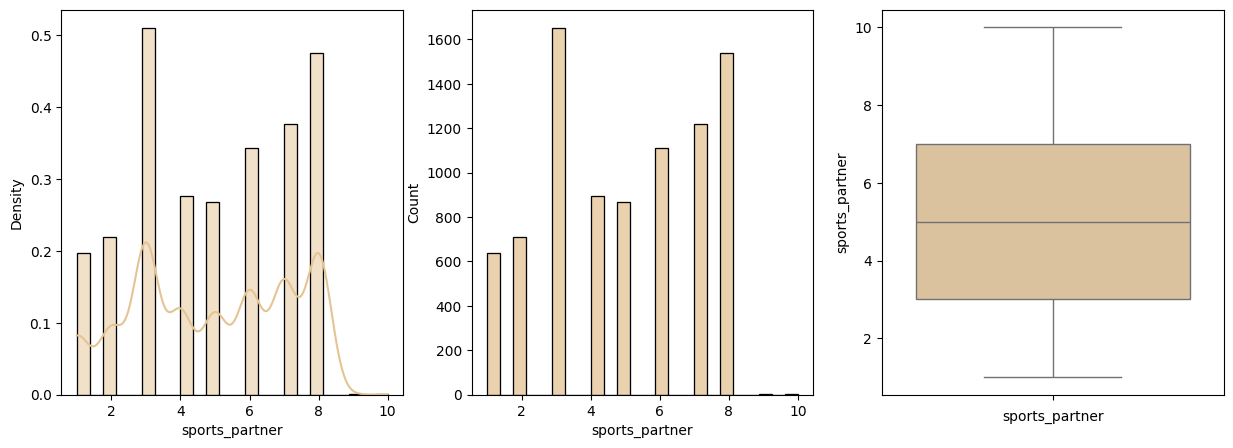

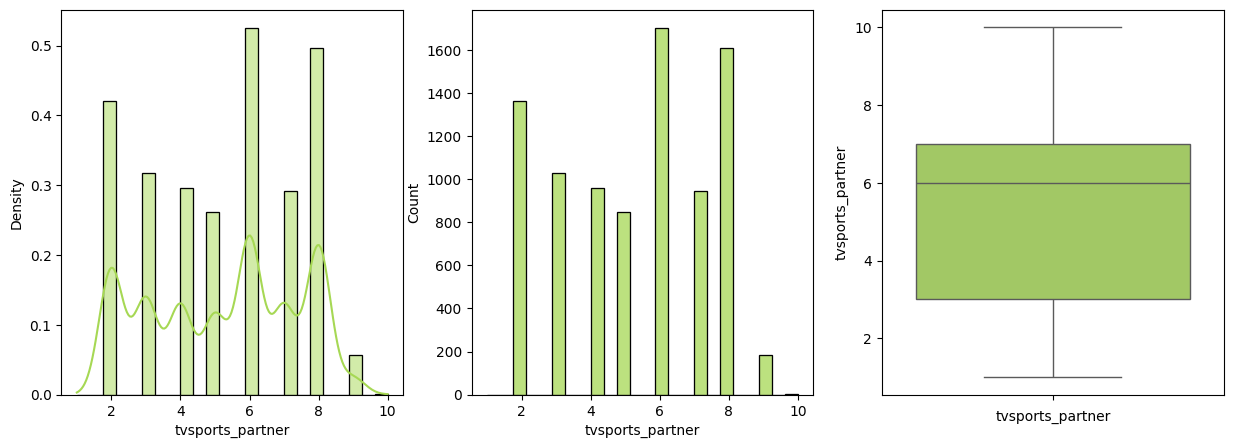

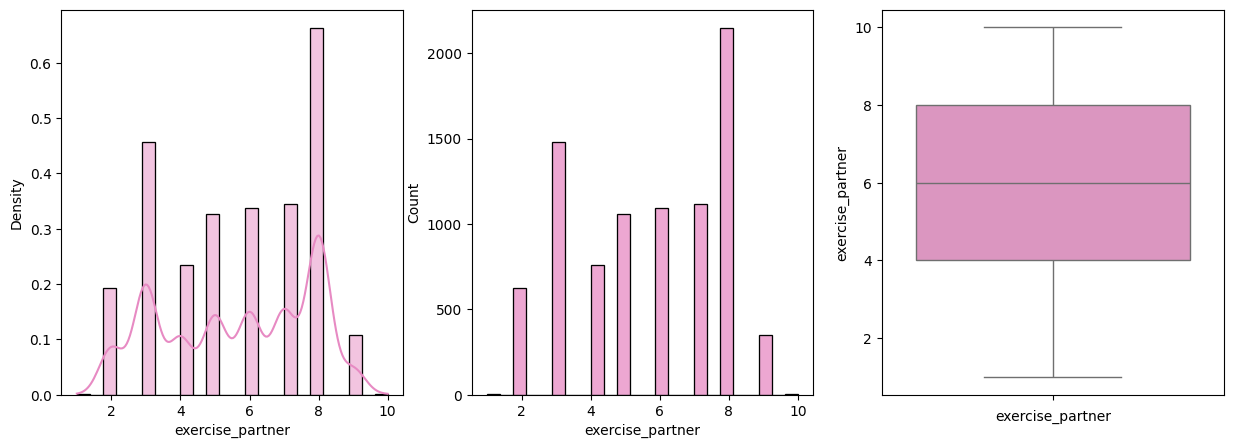

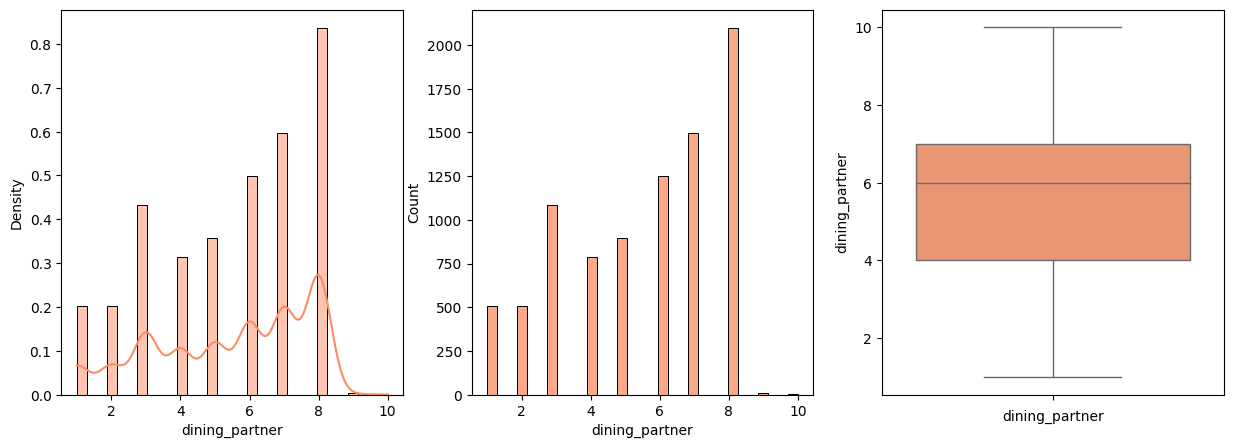

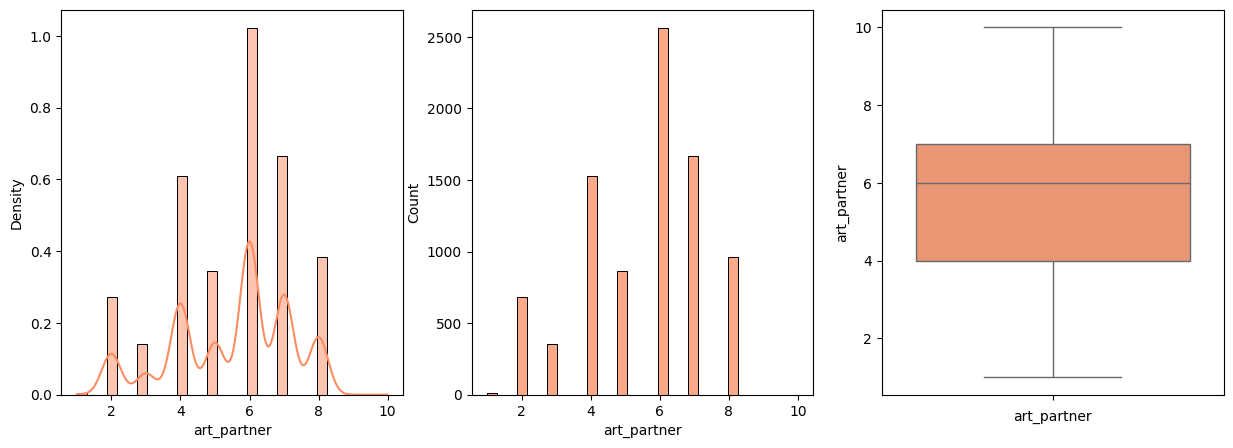

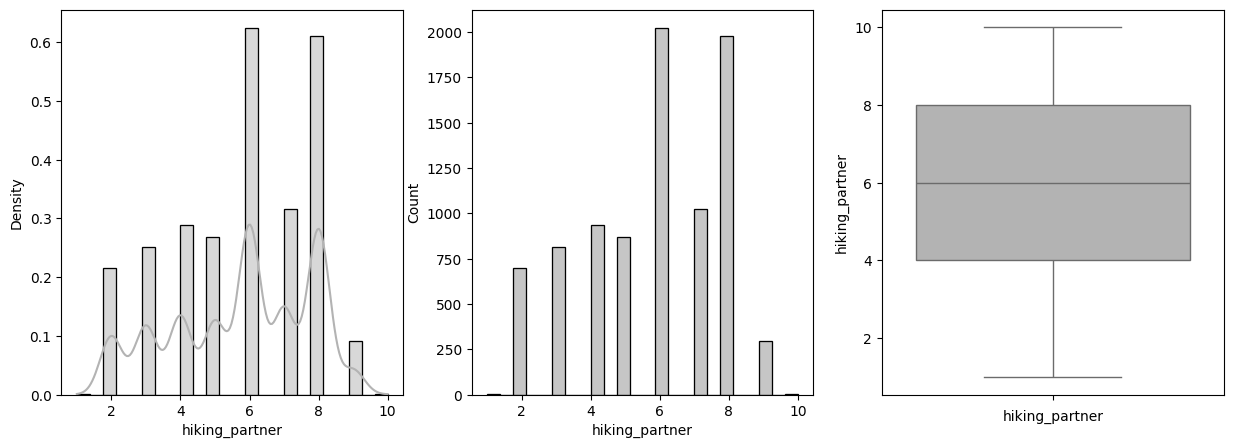

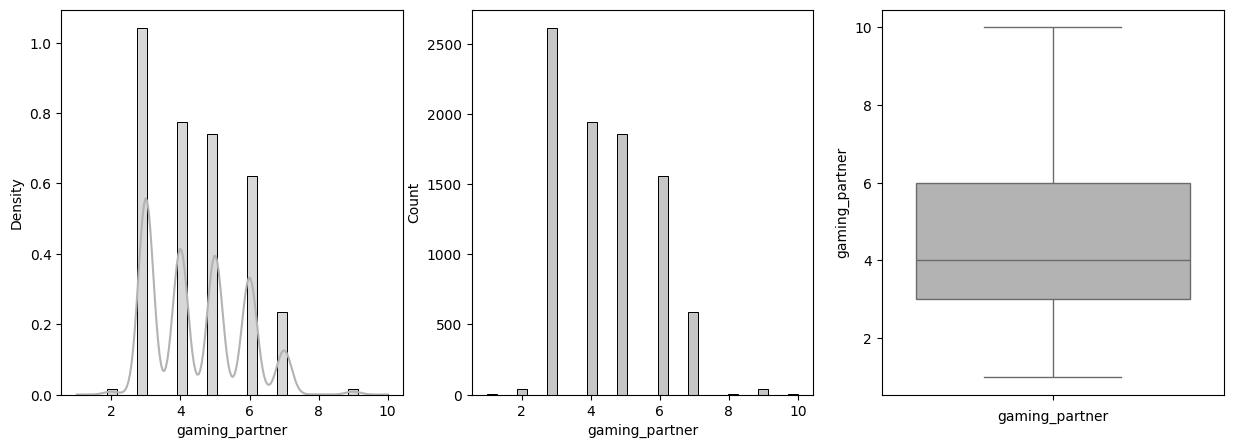

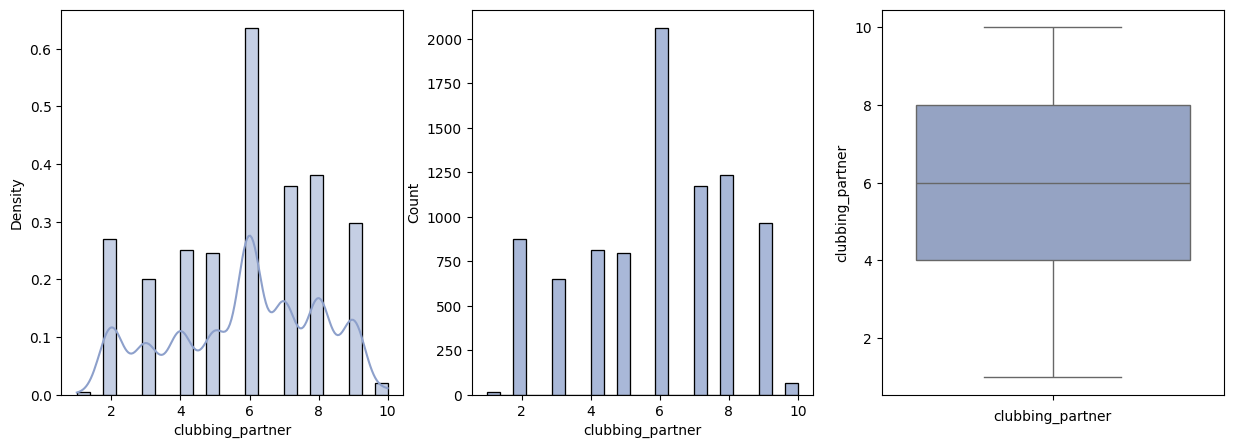

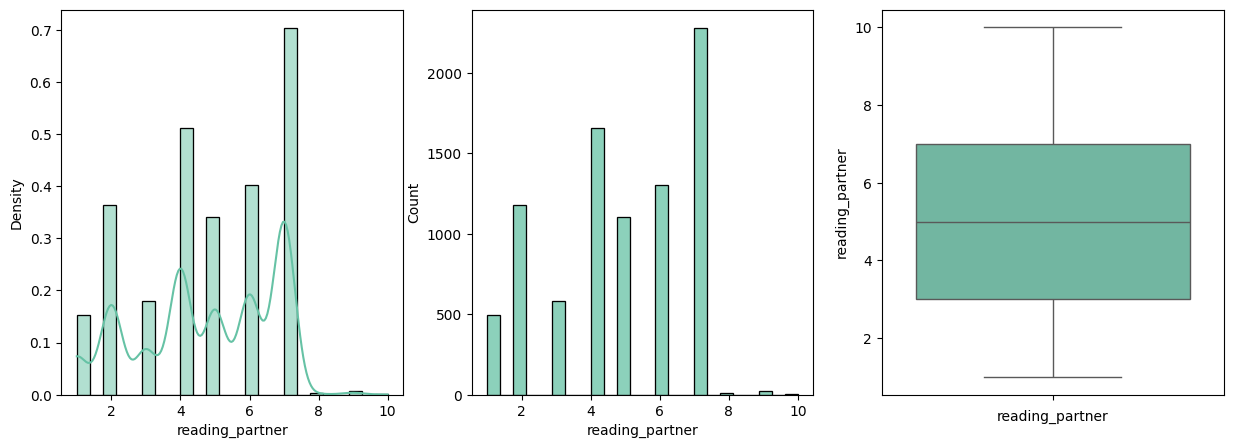

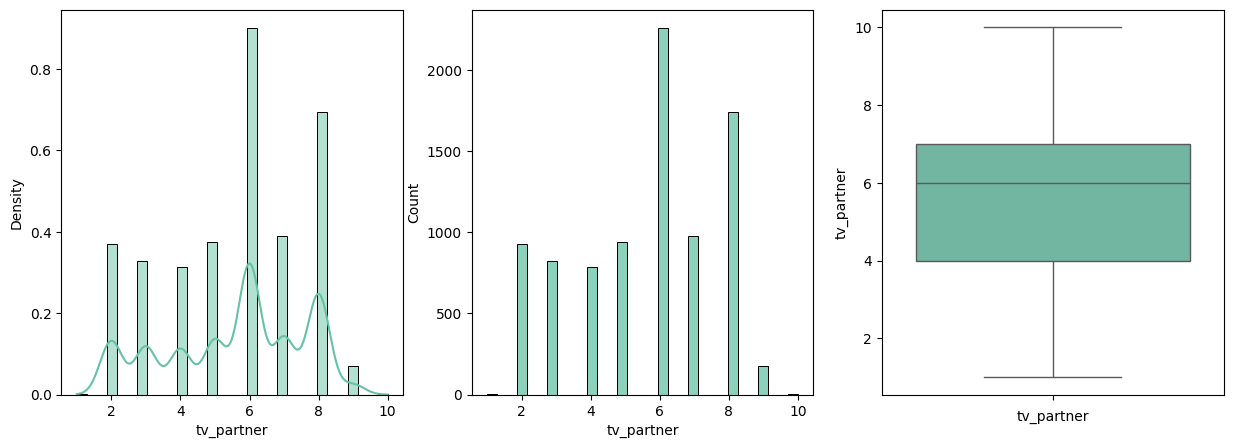

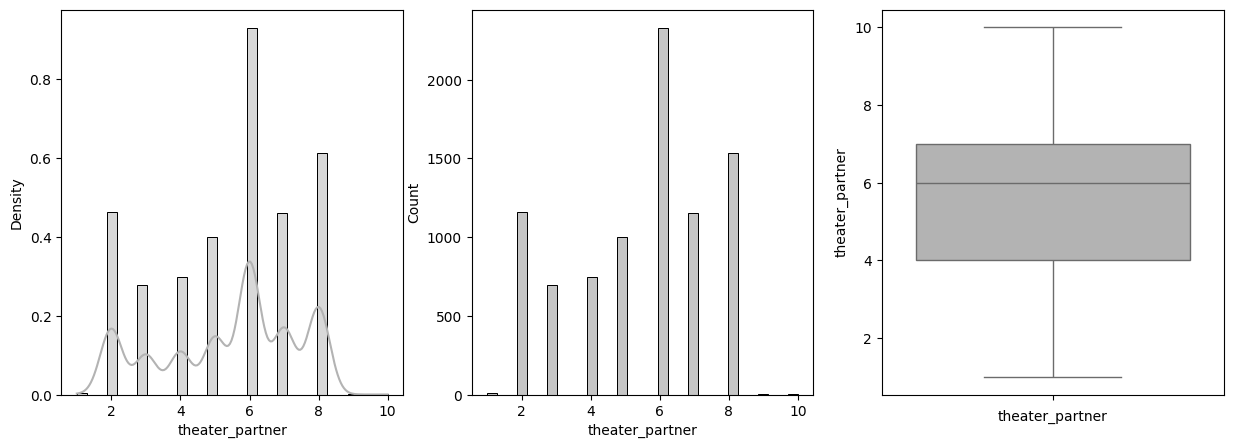

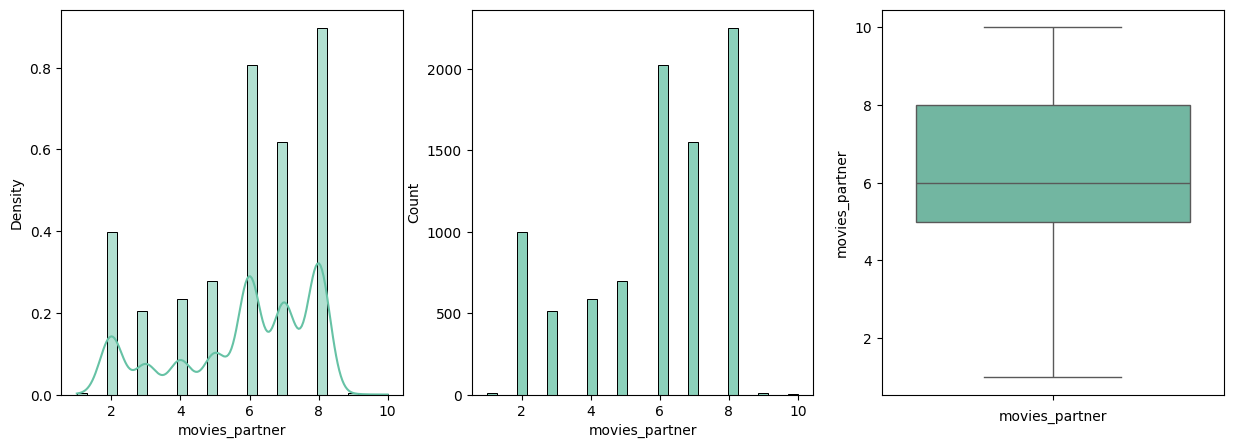

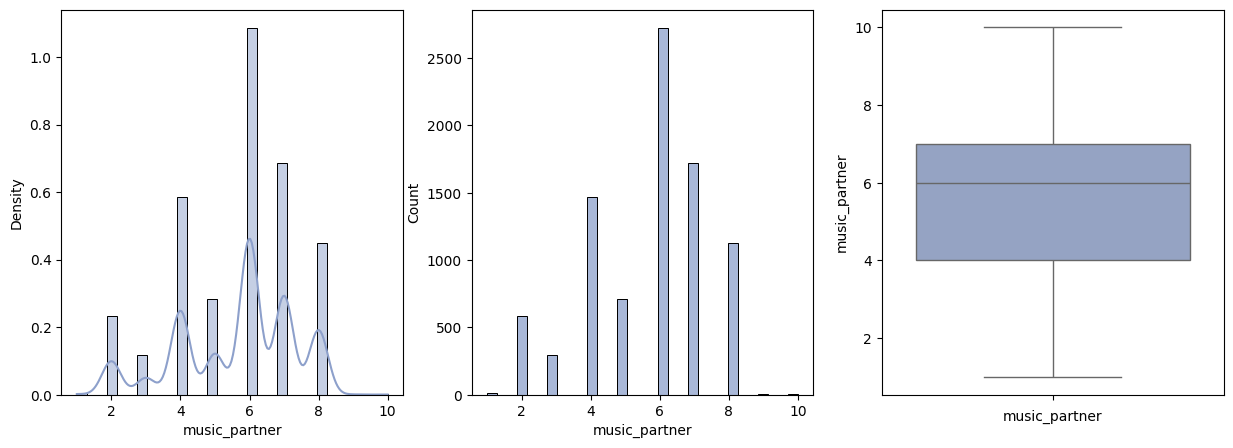

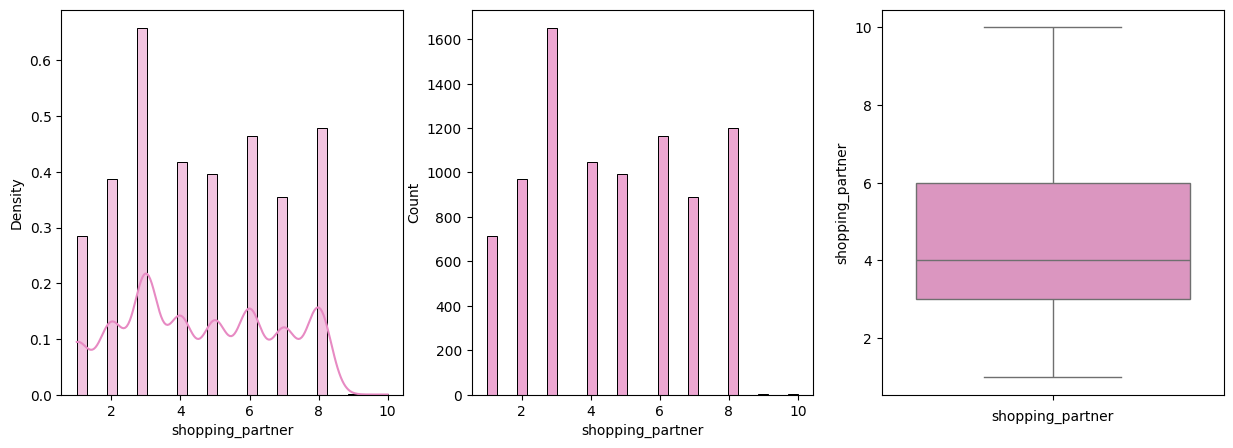

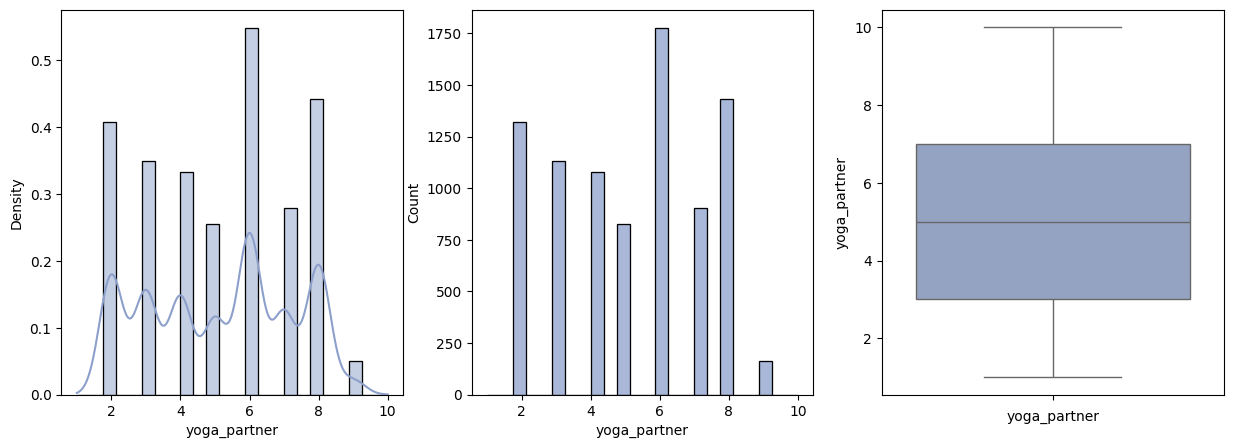

In [69]:
for column in partner_interests:
    grafici(dataset_v4[column])

<Axes: title={'center': 'Correlation Matrix'}>

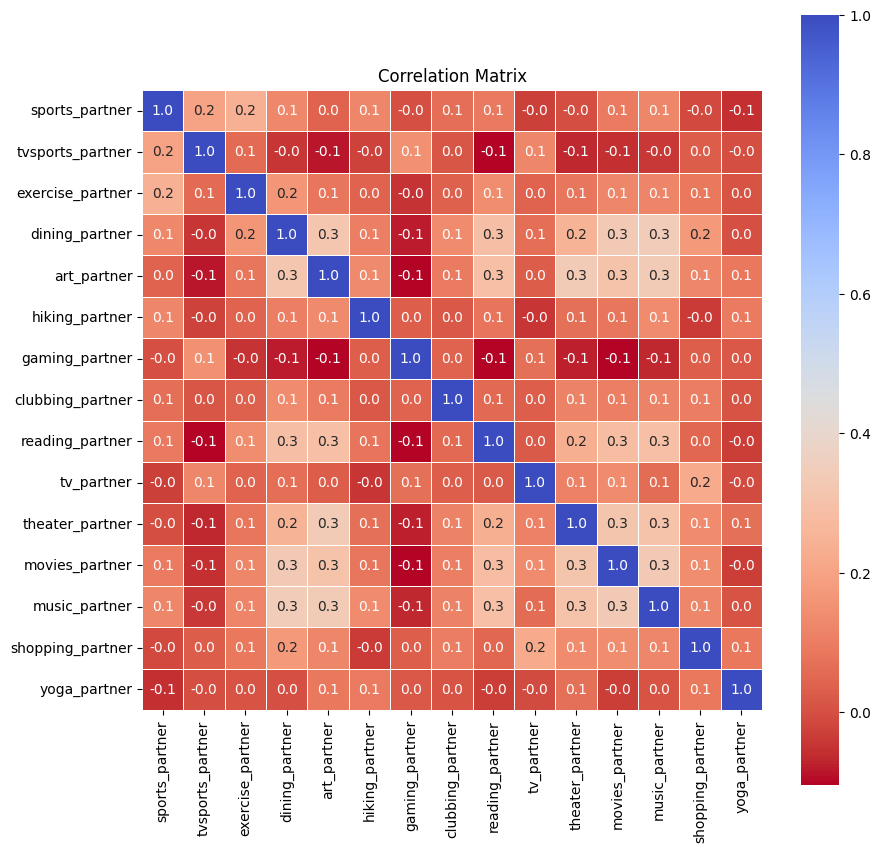

In [70]:
#matrice di correlazione ridotta
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(data=dataset_v4[partner_interests].corr(), cmap = 'coolwarm_r',annot=True,fmt=".1f", linewidth=.5,square=True)

#Text-number#


In [71]:
#gender choose encoding
for i in range (0,len(list(dataset_v4['gender_partner_text'].values))):
  if dataset_v4['gender_partner_text'].loc[dataset_v4.index[i]] == 1.:
    gender_text.append("he,him")
  if dataset_v4['gender'].loc[dataset_v4.index[i]] == 2.:
    gender_text.append("she,her")
  if dataset_v4['gender'].loc[dataset_v4.index[i]] == 3.:
    gender_text.append("they,them")

In [72]:
dataset_v4.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8637 entries, 4612 to 1557
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age_o                   8637 non-null   float64
 1   attractive_important    8637 non-null   float64
 2   sincere_important       8637 non-null   float64
 3   intelligence_important  8637 non-null   float64
 4   funny_important         8637 non-null   float64
 5   ambition_important      8637 non-null   float64
 6   age                     8637 non-null   float64
 7   attractive              8637 non-null   float64
 8   sincere                 8637 non-null   float64
 9   intelligence            8637 non-null   float64
 10  funny                   8637 non-null   float64
 11  ambition                8637 non-null   float64
 12  gender                  8637 non-null   float64
 13  sports                  8637 non-null   float64
 14  tvsports                8637 non-null   fl

#Descrizione del dataset finale#

In [73]:
#conversione in int dei dati per i filtri
filtri = [ 'age',
           'age_o',
           'age_flag',
           'age_radius',
           'gender',
           'gender_partner_him',
           'gender_partner_her',
           'gender_partner_them',
           'distance_km',
           'interest_flag'
          ]
for column in filtri:
  dataset_v4[column] = pd.to_numeric(dataset_v4[column]).astype('Int64')

In [74]:
#ordino colonne in modo più leggibile
clustering = ['sports',
              'tvsports',
              'exercise',
              'dining',
              'art',
              'hiking',
              'gaming',
              'clubbing',
              'reading',
              'tv',
              'theater',
              'movies',
              'music',
              'shopping',
              'yoga',
              'sports_partner',
              'tvsports_partner',
              'exercise_partner',
              'dining_partner',
              'art_partner',
              'hiking_partner',
              'gaming_partner',
              'clubbing_partner',
              'reading_partner',
              'tv_partner',
              'theater_partner',
              'movies_partner',
              'music_partner',
              'shopping_partner',
              'yoga_partner',
              'attractive_important',
              'sincere_important',
              'intelligence_important',
              'funny_important',
              'ambition_important',
              'attractive',
              'sincere',
              'intelligence',
              'funny',
              'ambition'
            ]

filtri = [ 'age',
           'age_o',
           'age_flag',
           'age_radius',
           'longitude',
           'latitude',
           'distance_km',
           'interest_flag'
          ]

gender_col = ['gender',
              'gender_text',
              'gender_partner', #codifica array 3d (superflua se usi le flag successive)
              'gender_partner_him', #ho spezzato i valori degli array per partner cercato, flag per genere 1_> sì, 0 -> no
              'gender_partner_her',
              'gender_partner_them',
              'gender_partner_text'
          ]


In [75]:
dataset_v5 = pd.DataFrame()
dataset_v5[clustering] = dataset_v4[clustering]
dataset_v5[filtri] = dataset_v4[filtri]
dataset_v5[gender_col] = dataset_v4[gender_col]

In [76]:
# Faccio partire l'indice da 1
dataset_v5.index = range(1, len(dataset_v5) + 1)

In [77]:
dataset_v5.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8637 entries, 1 to 8637
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sports                  8637 non-null   float64
 1   tvsports                8637 non-null   float64
 2   exercise                8637 non-null   float64
 3   dining                  8637 non-null   float64
 4   art                     8637 non-null   float64
 5   hiking                  8637 non-null   float64
 6   gaming                  8637 non-null   float64
 7   clubbing                8637 non-null   float64
 8   reading                 8637 non-null   float64
 9   tv                      8637 non-null   float64
 10  theater                 8637 non-null   float64
 11  movies                  8637 non-null   float64
 12  music                   8637 non-null   float64
 13  shopping                8637 non-null   float64
 14  yoga                    8637 non-null   

In [78]:
dataset_v5.describe()
dataset_v5['age'].mean()

26.363204816487205

<Axes: title={'center': 'Correlation Matrix'}>

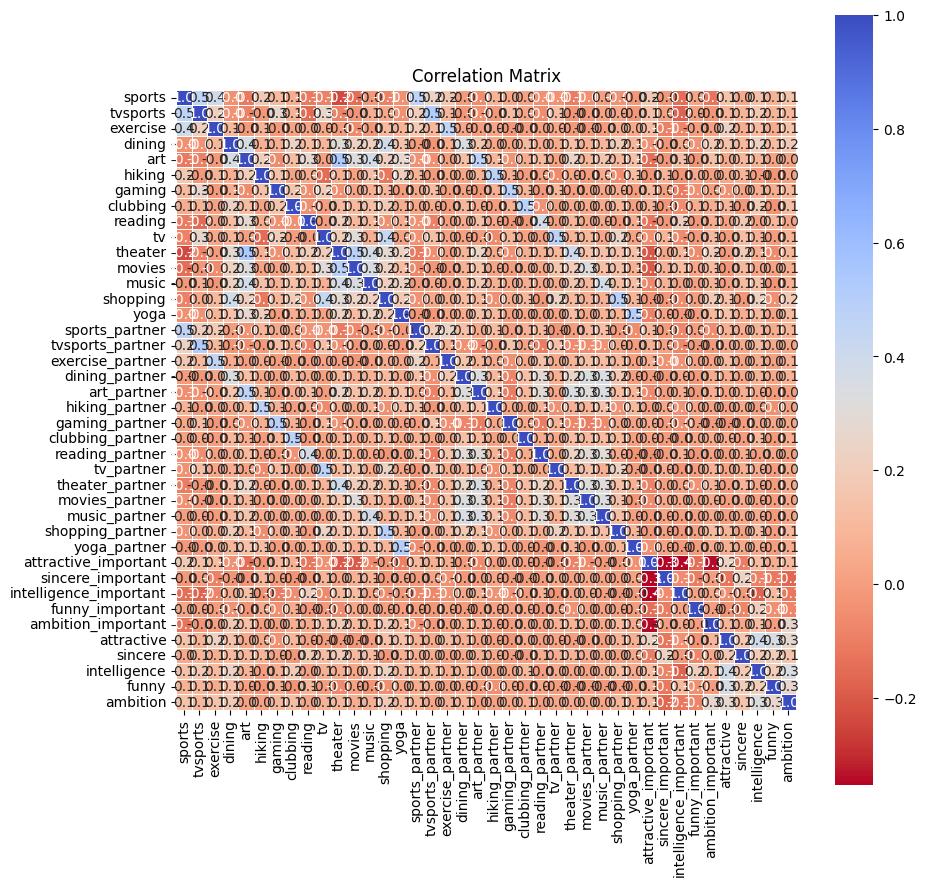

In [79]:
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(data=dataset_v5[clustering].corr(), cmap = 'coolwarm_r',annot=True,fmt=".1f", linewidth=.5,square=True)

#CSV#

In [80]:
dataset_v5.to_csv('dataset_END.csv')

#Controllo duplicati#

In [81]:
df = dataset_v5.copy()
df = df.drop(columns=['gender_partner_text','gender_text','gender_partner'])
dup = df.duplicated(keep=False).sum()
print(dup)

0


In [82]:
dataset_cluster = dataset_v5[clustering].copy()

In [83]:
duplicati_totali = dataset_cluster.duplicated(keep=False).sum()
print(duplicati_totali)

4198


#Clustering prova#

In [84]:
X = dataset_cluster.copy()
clusterer = HDBSCAN(min_cluster_size=7)
hdbs_labels = clusterer.fit_predict(X)

In [85]:
labels = list(hdbs_labels)
labels.sort()
labels = [str(x) for x in labels]

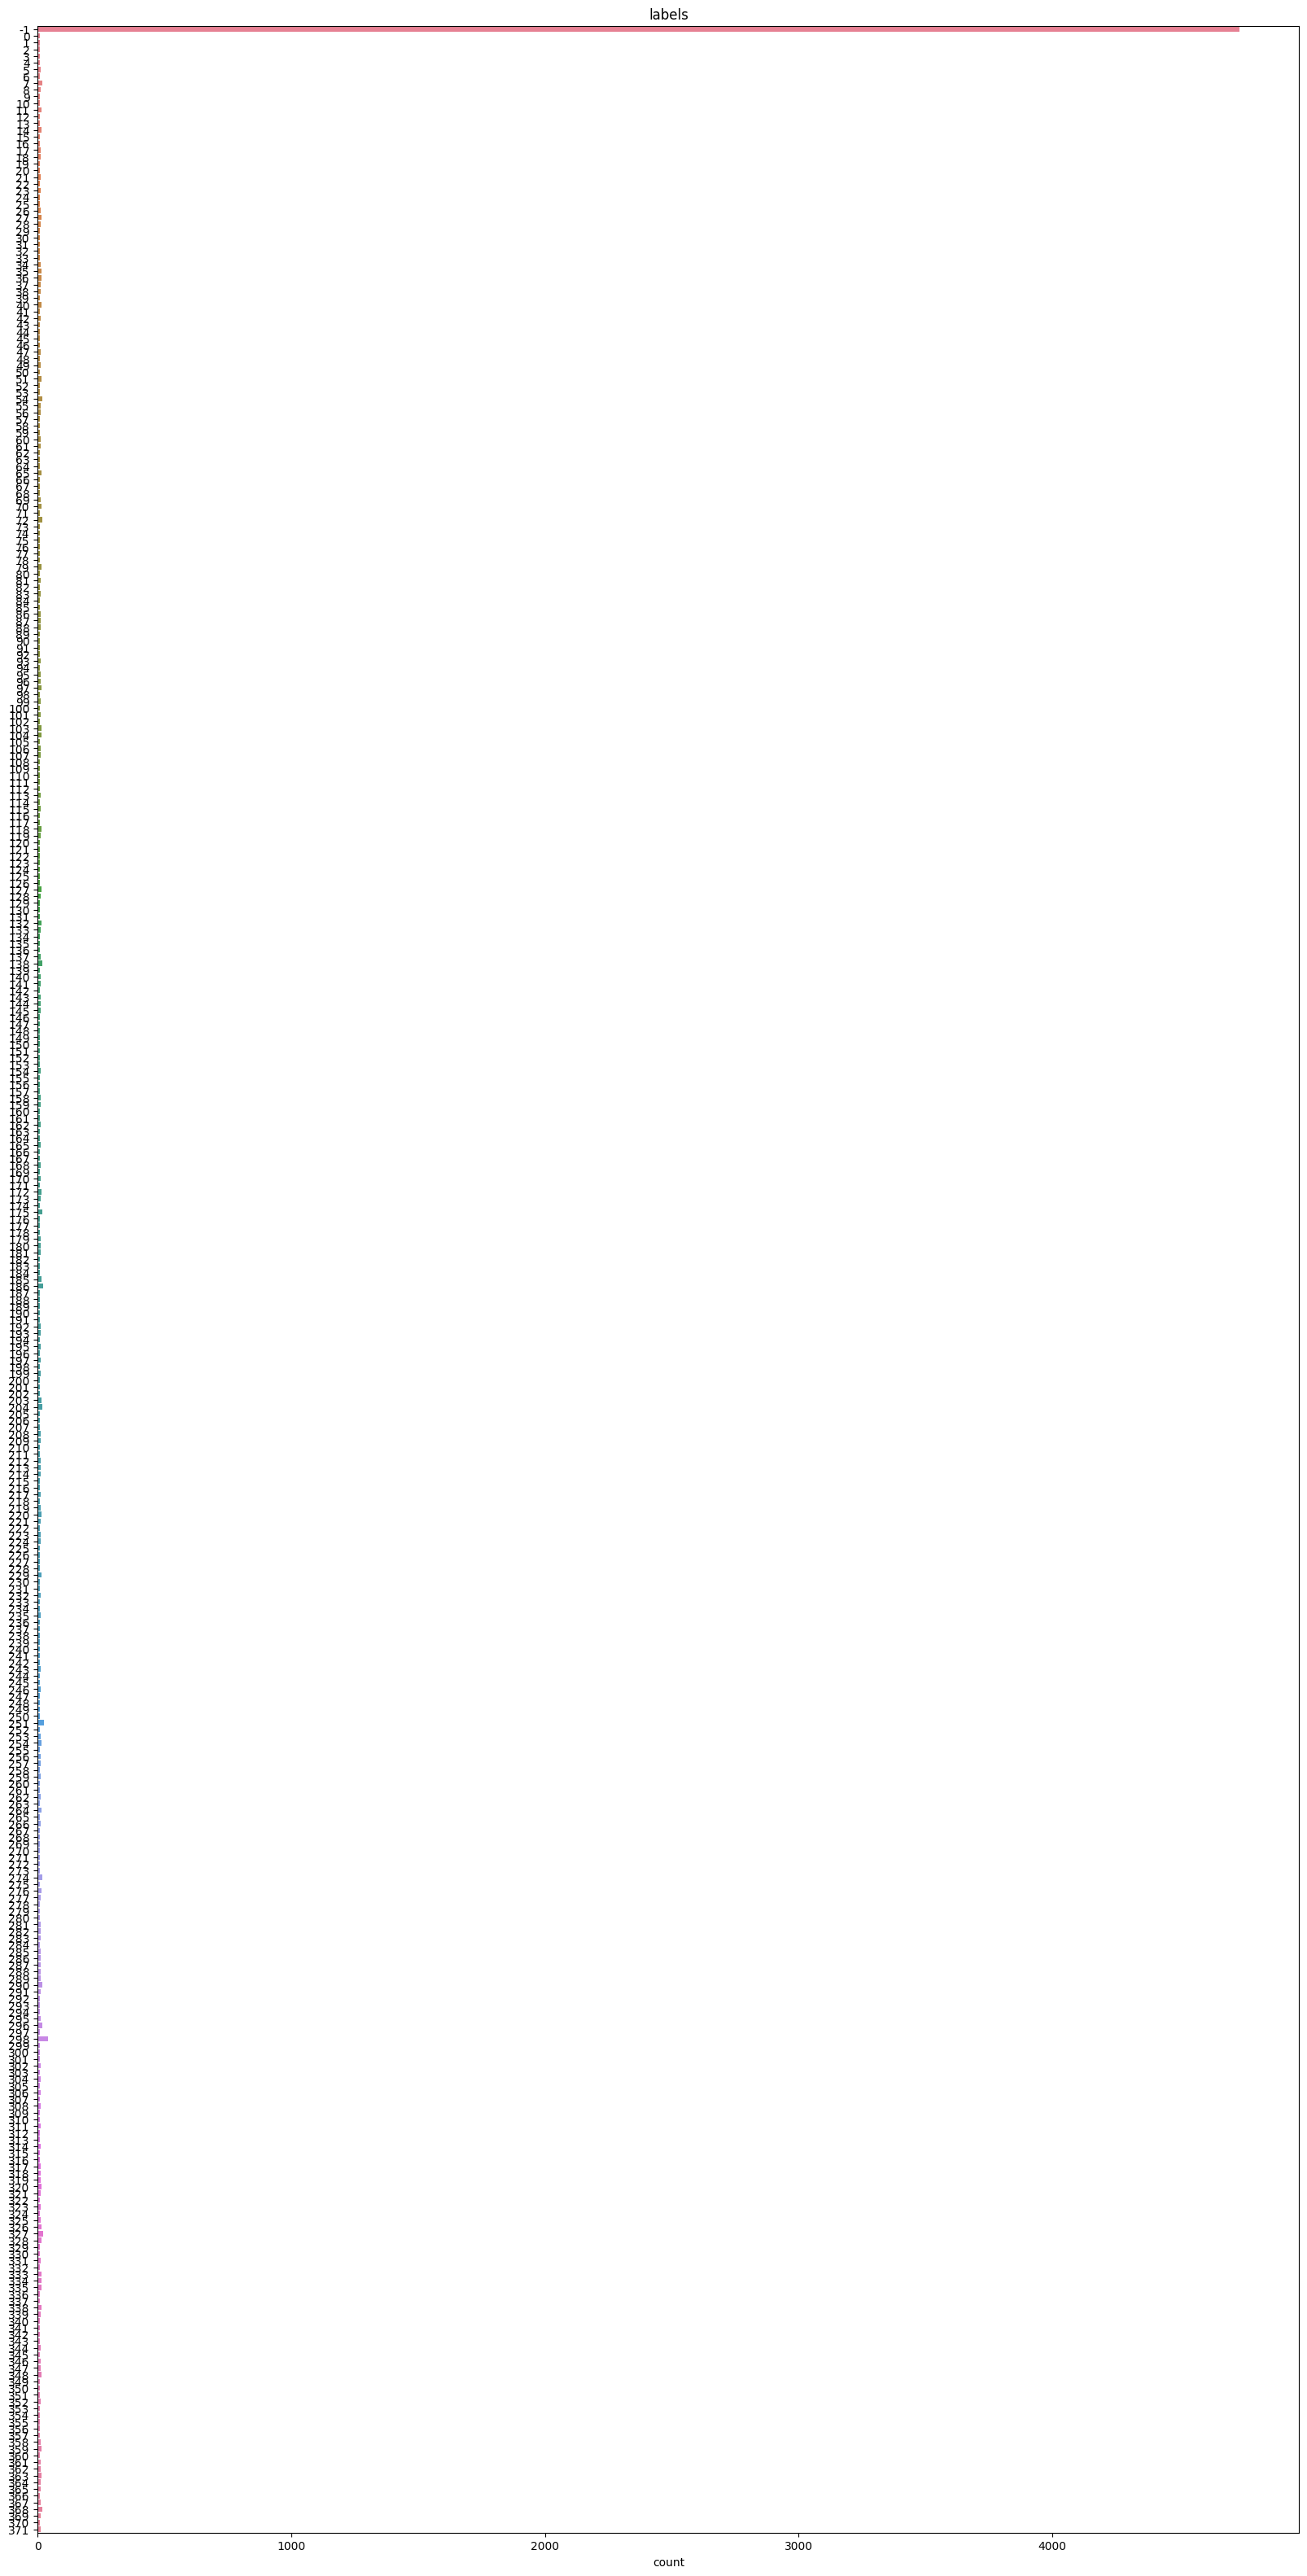

In [86]:
plt.figure(figsize=(20,40))
sns.countplot(y= labels, hue =labels)
plt.yticks(rotation=0,fontsize=10)
plt.title('labels')
plt.show()

#PCA#

In [87]:
X = dataset_cluster.copy()
pca = PCA()
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=hdbs_labels
    )
fig.update_traces(diagonal_visible=False)

In [88]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=hdbs_labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
)
fig.update_traces(marker=dict(size=1))
fig.show()

#TSNE#

<ipython-input-89-a87184be73f2>:8: UserWarning:

Mismatched number of handles and labels: len(handles) = 8 len(labels) = 373



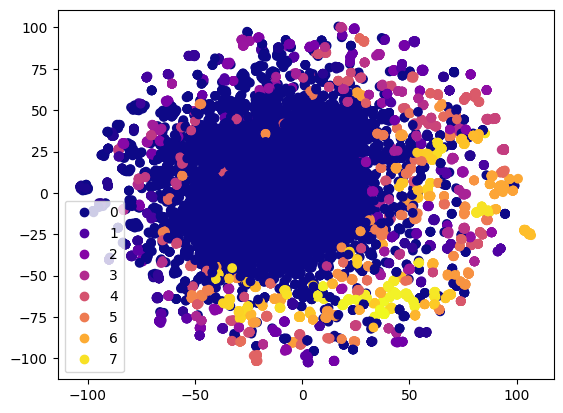

In [89]:
X = dataset_cluster.copy()
X_embeddedd = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30.0).fit_transform(X)
X_embeddedd.shape

labels = set(hdbs_labels)
fig = figsize = (15,15)
g = plt.scatter(X_embeddedd[:,0], X_embeddedd[:,1], c = hdbs_labels, cmap = 'plasma')
plt.legend(handles=g.legend_elements()[0], labels=labels)